# Multivariate Time Series Prediction Using Transformers Architecture

The following Notebook shows the coding part of my Bachelor Thesis for the Information and Communication Systems and Services bachelor degree in the University of Applied Science Technikum Wien.

Author: Sergio Tallo Torres
Date: April 2022

# First: load imports needed for the project and project preparation

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 323 (delta 45), reused 23 (delta 4), pack-reused 226
Receiving objects: 100% (323/323), 28.03 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (184/184), done.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import statistics
import torch
import math
import sklearn
import scipy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from datetime import datetime
from tqdm import tqdm
from scipy import stats
from platform import python_version
from torch import Tensor, float32, sin, cos
from google.colab import files

import utils_bsc

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla P100-PCIE-16GB


In [3]:

print('versions of packages:')
print(f'Python: {python_version()}')
print(f'Pandas: {pd.__version__}')
print(f'Numpy: {np.__version__}')
print(f'PyTorch: {torch.__version__}')
print(f'Sklearn: {sklearn.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'scipy: {scipy.__version__}')

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.11.0+cu113
Sklearn: 1.0.2
seaborn: 0.11.2
scipy: 1.4.1


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the value of the previous elemnt in the sequence).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
print_data = False
print_graphs = False

In [7]:
if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [8]:
if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [9]:
# We print some graphs showing the density distribution of every feature
if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [10]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [11]:
if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [12]:
if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very different. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [13]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [14]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 534.74it/s]


In [15]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 987.21it/s]


In [16]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1031.70it/s]


In [17]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [18]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [19]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


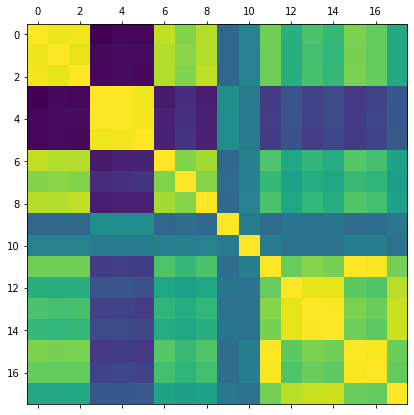

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810274, 0.16335739298653476, 0.07511546472382995, 0.054921627068028424, 0.05390616867076577, 0.04952232661739343, 0.022486349463995598, 0.013932731902136385, 0.012792662672300325, 0.009829012007199104, 0.004024926426955747, 0.002893959610103366, 0.002163271201445878, 0.001741116222641519, 0.0006928432299862775, 0.00021826337426103455, 0.00023351820917083064, 0.0004035851322244031]


In [20]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [21]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = stats.pearsonr(dataset_norm[i], dataset_norm[j])[0]
    if i != j:
      correlations.append(abs(correlation))
      feature.append(abs(correlation))
      print(correlation)
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686162
Correlation between PLN1 and PLN3
0.9606664987977854
Correlation between PLN1 and ULL1
-0.7274016376341781
Correlation between PLN1 and ULL2
-0.6955282277514699
Correlation between PLN1 and ULL3
-0.7030835410050383
Correlation between PLN1 and COS_PHI1
0.8410401295195358
Correlation between PLN1 and COS_PHI2
0.6731338062873106
Correlation between PLN1 and COS_PHI3
0.8122370309192151
Correlation between PLN1 and FREQ
-0.1545159794969927
Correlation between PLN1 and RC_DC
0.04144790238090616
Correlation between PLN1 and RC_AC
0.6311099014117806
Correlation between PLN1 and RC_50Hz
0.3688113546135111
Correlation between PLN1 and RC_150Hz
0.5078743784519382
Correlation between PLN1 and RC_<100Hz
0.43093253308676593
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453893
Correlation between PLN1 and RC_>1kHz
0.5928797475823843
Correlation between PLN1 and RC_>10kHz
0.3161918341465538
Mean of PLN1 co

In [22]:
# Covariance matrix, eigenvalues and explained variance

covmatrix = dataset_norm.cov()
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

acc = 0

for i, eigen in enumerate(eigenvalues):
  acc += eigen/np.sum(eigenvalues)
  print(f'Explained_variance {i +1} principal component: {eigen/np.sum(eigenvalues)} (accumulated {round(acc, 4)})')

Explained_variance 1 principal component: 0.5317647804810274 (accumulated 0.5318)
Explained_variance 2 principal component: 0.16335739298653476 (accumulated 0.6951)
Explained_variance 3 principal component: 0.07511546472382995 (accumulated 0.7702)
Explained_variance 4 principal component: 0.054921627068028424 (accumulated 0.8252)
Explained_variance 5 principal component: 0.05390616867076577 (accumulated 0.8791)
Explained_variance 6 principal component: 0.04952232661739343 (accumulated 0.9286)
Explained_variance 7 principal component: 0.022486349463995598 (accumulated 0.9511)
Explained_variance 8 principal component: 0.013932731902136385 (accumulated 0.965)
Explained_variance 9 principal component: 0.012792662672300325 (accumulated 0.9778)
Explained_variance 10 principal component: 0.009829012007199104 (accumulated 0.9876)
Explained_variance 11 principal component: 0.004024926426955747 (accumulated 0.9917)
Explained_variance 12 principal component: 0.002893959610103366 (accumulated 0.99

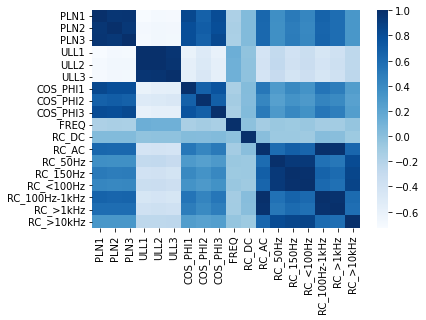

In [23]:
# Features correlations heat map

corr = dataset_norm.corr()
sns.heatmap(corr, cmap="Blues")

# Data loaders for the training

In [24]:
def create_sequece_dataloaders_new(dataset_norm, seq_length, batch_size):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of seq_length measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  assert seq_length > 1, f"sequence length should be greater than 1 expected, got: {seq_length}"

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - (seq_length +1))):    
    data = np.array(dataset_norm.iloc[i:i+seq_length, 1:])
    next = np.array(dataset_norm.iloc[i+seq_length, 1:], dtype= float)
    target = np.array(dataset_norm.iloc[i+(seq_length + 1), 1:], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=batch_size,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=batch_size,
      shuffle=True
  )

  return loader_train, loader_test

In [25]:
loader_train_seq, loader_test_seq = create_sequece_dataloaders_new(dataset_norm, 30, 16)

100%|██████████| 63329/63329 [00:40<00:00, 1582.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56996
length of test set (whole dataset): 6333




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [ ]:
def create_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=16,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=16,
      shuffle=True
  )

  return loader_train, loader_test

In [ ]:
loader_train, loader_test = create_dataloaders_new(dataset_norm)

100%|██████████| 63359/63359 [00:32<00:00, 1920.92it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [ ]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

# save to npy file
if False:
  np.save('baseline_train.npy', losses_train)
  np.save('baseline_test.npy', losses_test)

Training set
Mean Loss of baselinemodel:  0.47340006590951506
Standard deviation Loss of baselinemodel:  0.1774038643188757


Test set
Mean Loss of baselinemodel:  0.46949629177047747
Standard deviation Loss of baselinemodel:  0.18327590880998915




In [ ]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [ ]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN = ANN_relu(18, 18).to(device)
print(model_FFN)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN.parameters(), lr=lr)


train_FFN = False

params_not_trained_whole = model_FFN.parameters()

start_time = datetime.now()
if train_FFN is True:
  trained_model_FFN , train_losses_FFN, test_losses_FFN = train(model_FFN, criterion, optimizer_whole, loader_train, loader_test, n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'\nTraining time: {execution_time} seconds')

# save to npy file
if True:
  np.save('FFN_train.npy', losses_train)
  np.save('FFN_test.npy', losses_test)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Training time: 7.1e-05 seconds


In [ ]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_FFN))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_FFN], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_FFN], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

#min values in numpy array
minval = np.amin([np.mean(i) for i in test_losses_FFN])
print('min value in array:',minval)
indice = np.where([np.mean(i) for i in test_losses_FFN] == np.amin([np.mean(i) for i in test_losses_FFN]))
print('min value index:',indice[0])

NameError: ignored

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [26]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(self, seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)

        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        position_encoding = position_encoding.to(device)

        return position_encoding
        
    def forward (self, enc_input, dec_input):
        
        memory_mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src= src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=None, memory_mask=None)
        
        return output

In [27]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_1, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if False:
  np.save('Transformer_Vanilla_train.npy', train_losses_1)
  np.save('Transformer_Vanilla_test.npy', test_losses_1)

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_FFN], label= 'Train Loss Baseline model')

  ax.plot([np.mean(i) for i in train_losses_1], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_2, train_losses_2, test_losses_2 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

# save to npy file
if train_transformer is True:
  np.save('Transformer_ADAM_train.npy', train_losses_2)
  np.save('Transformer_ADAM_test.npy', test_losses_2)

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_2], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_2], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. ADAM")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_3, train_losses_3, test_losses_3 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

# save to npy file
if True:
  np.save('Transformer_SGDmom_train.npy', train_losses_3)
  np.save('Transformer_SGDmom_test.npy', test_losses_3)
  files.download('Transformer_SGDmom_train.npy') 
  files.download('Transformer_SGDmom_test.npy') 

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.42it/s]



Current Mean loss Train Set:  0.35455235590885903

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.51it/s]



Current Mean loss Test Set:  0.36299624564972793


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.28it/s]



Current Mean loss Train Set:  0.3413375794402408

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.59it/s]



Current Mean loss Test Set:  0.34956692072628726


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.03it/s]



Current Mean loss Train Set:  0.33264936092292663

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.93it/s]



Current Mean loss Test Set:  0.3402695669369264


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.99it/s]



Current Mean loss Train Set:  0.31629573011160766

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.56it/s]



Current Mean loss Test Set:  0.3217611018982198


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.38it/s]



Current Mean loss Train Set:  0.3138207645938867

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.62it/s]



Current Mean loss Test Set:  0.3202352596428057


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.47it/s]



Current Mean loss Train Set:  0.29326423390792256

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.86it/s]



Current Mean loss Test Set:  0.29886065382096505


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.33it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.10it/s]



Current Mean loss Train Set:  0.2984167037345103

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.47it/s]



Current Mean loss Test Set:  0.30434685584270593


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.71it/s]



Current Mean loss Train Set:  0.28563362694158

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.82it/s]



Current Mean loss Test Set:  0.2908018588116675


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.23it/s]



Current Mean loss Train Set:  0.28396195229304966

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.63it/s]



Current Mean loss Test Set:  0.28994448328710565


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.20it/s]



Current Mean loss Train Set:  0.2764734483328958

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.61it/s]



Current Mean loss Test Set:  0.28304579451379147


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.48it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.52it/s]



Current Mean loss Train Set:  0.2737693801990661

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.79it/s]



Current Mean loss Test Set:  0.2817369338990462


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.92it/s]



Current Mean loss Train Set:  0.2711038654761605

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.96it/s]



Current Mean loss Test Set:  0.27943743421047024


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.81it/s]



Current Mean loss Train Set:  0.26567205446274333

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.45it/s]



Current Mean loss Test Set:  0.2738732874318205


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.49it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.61it/s]



Current Mean loss Train Set:  0.26328192637261466

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.88it/s]



Current Mean loss Test Set:  0.27203465682087524


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.23it/s]



Current Mean loss Train Set:  0.2557202074054651

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.54it/s]



Current Mean loss Test Set:  0.2639703935369699


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.12it/s]



Current Mean loss Train Set:  0.24975384889970895

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.31it/s]



Current Mean loss Test Set:  0.25837321483501885


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.60it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.06it/s]



Current Mean loss Train Set:  0.249299782880096

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.33it/s]



Current Mean loss Test Set:  0.2586183325020653


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.77it/s]



Current Mean loss Train Set:  0.2464478744751712

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.58it/s]



Current Mean loss Test Set:  0.2512914212514656


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.63it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.82it/s]



Current Mean loss Train Set:  0.24368755262185107

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.74it/s]



Current Mean loss Test Set:  0.2515919516521572


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.99it/s]



Current Mean loss Train Set:  0.24170924895454785

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.07it/s]



Current Mean loss Test Set:  0.24837682023644447


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.66it/s]



Current Mean loss Train Set:  0.24301973538990274

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.28it/s]



Current Mean loss Test Set:  0.25060314986139837


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.68it/s]



Current Mean loss Train Set:  0.2403812778906109

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.47it/s]



Current Mean loss Test Set:  0.2460049626727899


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.79it/s]



Current Mean loss Train Set:  0.23810922423047762

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.29it/s]



Current Mean loss Test Set:  0.24392431645155555


Epoch: 24 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.07it/s]



Current Mean loss Train Set:  0.23927795612432298

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.52it/s]



Current Mean loss Test Set:  0.24678841856016656


Epoch: 25 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.19it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.85it/s]



Current Mean loss Train Set:  0.23949891096908926

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.44it/s]



Current Mean loss Test Set:  0.2435394817342361


Epoch: 26 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.67it/s]



Current Mean loss Train Set:  0.23387234953056718

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.58it/s]



Current Mean loss Test Set:  0.24106845918177355


Epoch: 27 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.06it/s]



Current Mean loss Train Set:  0.23160876354206286

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.44it/s]



Current Mean loss Test Set:  0.2398610736121132


Epoch: 28 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.10it/s]



Current Mean loss Train Set:  0.23445382416499252

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.69it/s]



Current Mean loss Test Set:  0.24229015377961627


Epoch: 29 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.99it/s]



Current Mean loss Train Set:  0.2369825246751961

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.53it/s]



Current Mean loss Test Set:  0.24473959606404255


Epoch: 30 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.06it/s]



Current Mean loss Train Set:  0.2339947152796034

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.60it/s]



Current Mean loss Test Set:  0.24228270237117705


Epoch: 31 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.96it/s]



Current Mean loss Train Set:  0.22984213372595752

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.33it/s]



Current Mean loss Test Set:  0.23915532370558892


Epoch: 32 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.48it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.41it/s]



Current Mean loss Train Set:  0.2330363385071923

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.59it/s]



Current Mean loss Test Set:  0.23993503859247825


Epoch: 33 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.88it/s]



Current Mean loss Train Set:  0.22931748735680527

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.85it/s]



Current Mean loss Test Set:  0.23785624148869755


Epoch: 34 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.71it/s]



Current Mean loss Train Set:  0.23175813128673525

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.16it/s]



Current Mean loss Test Set:  0.2413431518532411


Epoch: 35 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.18it/s]



Current Mean loss Train Set:  0.22878943112687453

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.44it/s]



Current Mean loss Test Set:  0.23856058647159975


Epoch: 36 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.38it/s]



Current Mean loss Train Set:  0.22965612582425338

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.63it/s]



Current Mean loss Test Set:  0.2396261694304871


Epoch: 37 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.87it/s]



Current Mean loss Train Set:  0.22747406234048304

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.15it/s]



Current Mean loss Test Set:  0.23694958955501066


Epoch: 38 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.48it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.00it/s]



Current Mean loss Train Set:  0.22478594148331332

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.26it/s]



Current Mean loss Test Set:  0.23429222864032995


Epoch: 39 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.39it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.69it/s]



Current Mean loss Train Set:  0.22593683575039797

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.41it/s]



Current Mean loss Test Set:  0.2338082344092504


Epoch: 40 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.49it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.51it/s]



Current Mean loss Train Set:  0.22459929985567456

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.85it/s]



Current Mean loss Test Set:  0.23545502060365797


Epoch: 41 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.26it/s]



Current Mean loss Train Set:  0.22448164446699195

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.74it/s]



Current Mean loss Test Set:  0.23271361653777686


Epoch: 42 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.40it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.26it/s]



Current Mean loss Train Set:  0.2257264419833897

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.83it/s]



Current Mean loss Test Set:  0.23712955117978232


Epoch: 43 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.86it/s]



Current Mean loss Train Set:  0.22767089642929356

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.32it/s]



Current Mean loss Test Set:  0.23712343365104513


Epoch: 44 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.47it/s]



Current Mean loss Train Set:  0.22124409695254463

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.34it/s]



Current Mean loss Test Set:  0.23086606504188645


Epoch: 45 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.99it/s]



Current Mean loss Train Set:  0.22572807143352155

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.33it/s]



Current Mean loss Test Set:  0.2339917111840814


Epoch: 46 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.38it/s]



Current Mean loss Train Set:  0.2289084335943303

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.13it/s]



Current Mean loss Test Set:  0.2420885953864064


Epoch: 47 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.20it/s]



Current Mean loss Train Set:  0.22194688947656468

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.57it/s]



Current Mean loss Test Set:  0.2326932939691375


Epoch: 48 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.40it/s]



Current Mean loss Train Set:  0.2237357451859365

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.44it/s]



Current Mean loss Test Set:  0.23467654189226603


Epoch: 49 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.59it/s]



Current Mean loss Train Set:  0.22004342228676074

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.79it/s]



Current Mean loss Test Set:  0.23194065881949483


Epoch: 50 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.43it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.58it/s]



Current Mean loss Train Set:  0.22002920937477924

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.90it/s]



Current Mean loss Test Set:  0.2307062279809304


Epoch: 51 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.53it/s]



Current Mean loss Train Set:  0.21869713702447421

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.20it/s]



Current Mean loss Test Set:  0.22957186120552847


Epoch: 52 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.68it/s]



Current Mean loss Train Set:  0.21802188530083355

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.01it/s]



Current Mean loss Test Set:  0.22991632914753876


Epoch: 53 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.69it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.22it/s]



Current Mean loss Train Set:  0.22019325000807172

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.05it/s]



Current Mean loss Test Set:  0.23163744216464988


Epoch: 54 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.99it/s]



Current Mean loss Train Set:  0.21897460052488962

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.36it/s]



Current Mean loss Test Set:  0.23007761327681517


Epoch: 55 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.56it/s]



Current Mean loss Train Set:  0.21831014583636427

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.61it/s]



Current Mean loss Test Set:  0.23061229218964022


Epoch: 56 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.49it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.18it/s]



Current Mean loss Train Set:  0.22142184666668202

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.43it/s]



Current Mean loss Test Set:  0.23101013460469366


Epoch: 57 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.46it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.56it/s]



Current Mean loss Train Set:  0.21749904418456698

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.91it/s]



Current Mean loss Test Set:  0.23080106909302148


Epoch: 58 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.65it/s]



Current Mean loss Train Set:  0.2178809177104322

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.22it/s]



Current Mean loss Test Set:  0.23154203100788473


Epoch: 59 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.58it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.39it/s]



Current Mean loss Train Set:  0.21605639775298532

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.03it/s]



Current Mean loss Test Set:  0.22735873257948291


Epoch: 60 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.53it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.61it/s]



Current Mean loss Train Set:  0.21654751633798142

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.93it/s]



Current Mean loss Test Set:  0.23068153991768456


Epoch: 61 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.06it/s]



Current Mean loss Train Set:  0.21606055334306587

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.19it/s]



Current Mean loss Test Set:  0.22707283617270113


Epoch: 62 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.40it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.00it/s]



Current Mean loss Train Set:  0.21840878653410878

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.99it/s]



Current Mean loss Test Set:  0.23268168398903477


Epoch: 63 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.66it/s]



Current Mean loss Train Set:  0.21841977563026144

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.44it/s]



Current Mean loss Test Set:  0.2294209601000102


Epoch: 64 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.39it/s]



Current Mean loss Train Set:  0.21572865749004347

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.66it/s]



Current Mean loss Test Set:  0.22905767063676108


Epoch: 65 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.73it/s]



Current Mean loss Train Set:  0.21738662445039988

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.09it/s]



Current Mean loss Test Set:  0.23064433950742688


Epoch: 66 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.26it/s]



Current Mean loss Train Set:  0.21515888019814908

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.70it/s]



Current Mean loss Test Set:  0.22917436392545099


Epoch: 67 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.53it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.61it/s]



Current Mean loss Train Set:  0.21302510253873863

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.95it/s]



Current Mean loss Test Set:  0.22462724847248708


Epoch: 68 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.47it/s]



Current Mean loss Train Set:  0.21654244676470724

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.68it/s]



Current Mean loss Test Set:  0.22854404636856282


Epoch: 69 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.04it/s]



Current Mean loss Train Set:  0.21926662680090997

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.38it/s]



Current Mean loss Test Set:  0.2320859707854312


Epoch: 70 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.99it/s]



Current Mean loss Train Set:  0.21256924913257755

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.75it/s]



Current Mean loss Test Set:  0.2242167614814308


Epoch: 71 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.79it/s]



Current Mean loss Train Set:  0.21632429404085418

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.38it/s]



Current Mean loss Test Set:  0.2308395193381743


Epoch: 72 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.02it/s]



Current Mean loss Train Set:  0.21226675763052902

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.15it/s]



Current Mean loss Test Set:  0.22677400708198547


Epoch: 73 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.74it/s]



Current Mean loss Train Set:  0.21184761987002151

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.44it/s]



Current Mean loss Test Set:  0.22681501639461277


Epoch: 74 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.48it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.54it/s]



Current Mean loss Train Set:  0.2132643228174594

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.72it/s]



Current Mean loss Test Set:  0.22751549911694696


Epoch: 75 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.22it/s] 



Current Mean loss Train Set:  0.21967030520473274

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.85it/s]



Current Mean loss Test Set:  0.23116451351329534


Epoch: 76 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.49it/s]



Current Mean loss Train Set:  0.21415352886383232

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.70it/s]



Current Mean loss Test Set:  0.22676264346022196


Epoch: 77 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.94it/s]



Current Mean loss Train Set:  0.21689984965635556

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.06it/s] 



Current Mean loss Test Set:  0.23422287007549195


Epoch: 78 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.57it/s] 



Current Mean loss Train Set:  0.21207431659892875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.35it/s]



Current Mean loss Test Set:  0.2285770271537882


Epoch: 79 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.68it/s]



Current Mean loss Train Set:  0.21057355950722156

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.00it/s]



Current Mean loss Test Set:  0.22454103731522054


Epoch: 80 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.14it/s]



Current Mean loss Train Set:  0.21201632747548435

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.12it/s]



Current Mean loss Test Set:  0.2265559116547758


Epoch: 81 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.10it/s]



Current Mean loss Train Set:  0.21064039414689475

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.19it/s]



Current Mean loss Test Set:  0.224512599201666


Epoch: 82 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.87it/s] 



Current Mean loss Train Set:  0.21558375461505364

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.50it/s] 



Current Mean loss Test Set:  0.23011390230797155


Epoch: 83 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.12it/s]



Current Mean loss Train Set:  0.21030427788604086

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.60it/s]



Current Mean loss Test Set:  0.2279014497656714


Epoch: 84 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.25it/s]



Current Mean loss Train Set:  0.20801493374109603

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.43it/s]



Current Mean loss Test Set:  0.2233969931951677


Epoch: 85 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.37it/s]



Current Mean loss Train Set:  0.20973108684810868

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.57it/s]



Current Mean loss Test Set:  0.22400392375585407


Epoch: 86 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.33it/s]



Current Mean loss Train Set:  0.2088738064684963

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.59it/s] 



Current Mean loss Test Set:  0.2260320893479417


Epoch: 87 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.68it/s]



Current Mean loss Train Set:  0.20860539361470676

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.70it/s]



Current Mean loss Test Set:  0.22371387175011515


Epoch: 88 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.82it/s]



Current Mean loss Train Set:  0.20822784722211019

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.75it/s]



Current Mean loss Test Set:  0.22374096567356827


Epoch: 89 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.03it/s]



Current Mean loss Train Set:  0.20900366043161214

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.51it/s]



Current Mean loss Test Set:  0.22426621800269744


Epoch: 90 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.63it/s] 



Current Mean loss Train Set:  0.20776819530377855

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.50it/s] 



Current Mean loss Test Set:  0.22363578140585108


Epoch: 91 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.97it/s]



Current Mean loss Train Set:  0.2081456954099307

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.15it/s]



Current Mean loss Test Set:  0.22532557348033996


Epoch: 92 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.41it/s]



Current Mean loss Train Set:  0.21063884506391536

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.25it/s] 



Current Mean loss Test Set:  0.22620496114320826


Epoch: 93 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.42it/s] 



Current Mean loss Train Set:  0.20826357325793585

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.23it/s]



Current Mean loss Test Set:  0.22498411196048815


Epoch: 94 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.15it/s]



Current Mean loss Train Set:  0.2093918390013748

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.97it/s]



Current Mean loss Test Set:  0.22760816898686115


Epoch: 95 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.45it/s]



Current Mean loss Train Set:  0.20869359144443814

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.78it/s]



Current Mean loss Test Set:  0.22354040439758036


Epoch: 96 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.87it/s]



Current Mean loss Train Set:  0.20678003806094924

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.42it/s]



Current Mean loss Test Set:  0.22352268924993096


Epoch: 97 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.09it/s]



Current Mean loss Train Set:  0.2070320225162617

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.91it/s]



Current Mean loss Test Set:  0.22411971894854849


Epoch: 98 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.34it/s]



Current Mean loss Train Set:  0.20567504729141922

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.19it/s]



Current Mean loss Test Set:  0.22270121180800476


Epoch: 99 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.06it/s]



Current Mean loss Train Set:  0.20737756615796854

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.19it/s]



Current Mean loss Test Set:  0.22340666536580434


Epoch: 100 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.40it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.47it/s]



Current Mean loss Train Set:  0.2085448814775045

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.89it/s]



Current Mean loss Test Set:  0.22621732530645047


Epoch: 101 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.96it/s]



Current Mean loss Train Set:  0.2065067589659387

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.54it/s]



Current Mean loss Test Set:  0.22321129633546477


Epoch: 102 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.22it/s]



Current Mean loss Train Set:  0.20417747655561924

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.72it/s]



Current Mean loss Test Set:  0.22238585772463168


Epoch: 103 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.87it/s]



Current Mean loss Train Set:  0.20514289752263687

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.05it/s]



Current Mean loss Test Set:  0.22102553645769754


Epoch: 104 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.11it/s]



Current Mean loss Train Set:  0.20825009681796747

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.14it/s]



Current Mean loss Test Set:  0.22480743165795852


Epoch: 105 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.04it/s]



Current Mean loss Train Set:  0.20391437977159288

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.44it/s]



Current Mean loss Test Set:  0.2216262642595202


Epoch: 106 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.28it/s]



Current Mean loss Train Set:  0.20684452513622295

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.93it/s]



Current Mean loss Test Set:  0.22556323565617956


Epoch: 107 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.62it/s]



Current Mean loss Train Set:  0.20822192218918964

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.80it/s]



Current Mean loss Test Set:  0.22670806594418758


Epoch: 108 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.83it/s]



Current Mean loss Train Set:  0.20526109417310232

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.60it/s]



Current Mean loss Test Set:  0.2211140530616647


Epoch: 109 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.88it/s]



Current Mean loss Train Set:  0.20260979046555272

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.55it/s]



Current Mean loss Test Set:  0.22040076085338087


Epoch: 110 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.98it/s]



Current Mean loss Train Set:  0.2045448786073811

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.17it/s]



Current Mean loss Test Set:  0.22246795123198418


Epoch: 111 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.33it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.05it/s]



Current Mean loss Train Set:  0.20697692086396846

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.27it/s]



Current Mean loss Test Set:  0.22495600229336155


Epoch: 112 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.34it/s]



Current Mean loss Train Set:  0.2056952073475868

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.96it/s]



Current Mean loss Test Set:  0.22266208118937833


Epoch: 113 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.26it/s]



Current Mean loss Train Set:  0.20290201287815954

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.49it/s]



Current Mean loss Test Set:  0.22246950706749252


Epoch: 114 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.77it/s]



Current Mean loss Train Set:  0.20340505434310474

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.83it/s]



Current Mean loss Test Set:  0.22142194412799196


Epoch: 115 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.40it/s]



Current Mean loss Train Set:  0.2038146811938674

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.89it/s] 



Current Mean loss Test Set:  0.2242818001206174


Epoch: 116 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.01it/s]



Current Mean loss Train Set:  0.204520374530241

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.30it/s]



Current Mean loss Test Set:  0.2240137266314993


Epoch: 117 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.52it/s]



Current Mean loss Train Set:  0.205203956345929

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.93it/s]



Current Mean loss Test Set:  0.22412198343587042


Epoch: 118 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.33it/s]



Current Mean loss Train Set:  0.20337396588070888

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.66it/s]



Current Mean loss Test Set:  0.22129668120407697


Epoch: 119 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.34it/s]



Current Mean loss Train Set:  0.20468139121690027

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.47it/s]



Current Mean loss Test Set:  0.22314637026401482


Epoch: 120 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.34it/s]



Current Mean loss Train Set:  0.20397168474228503

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.24it/s]



Current Mean loss Test Set:  0.22386040670251606


Epoch: 121 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.43it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.51it/s]



Current Mean loss Train Set:  0.20022807926056663

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.55it/s]



Current Mean loss Test Set:  0.22217239661499708


Epoch: 122 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.98it/s]



Current Mean loss Train Set:  0.20307459990872181

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.79it/s]



Current Mean loss Test Set:  0.2244351850540349


Epoch: 123 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.54it/s]



Current Mean loss Train Set:  0.20186558065749338

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.13it/s]



Current Mean loss Test Set:  0.2219173734386762


Epoch: 124 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.20it/s]



Current Mean loss Train Set:  0.200588827699197

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.34it/s]



Current Mean loss Test Set:  0.22213993750211566


Epoch: 125 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.18it/s]



Current Mean loss Train Set:  0.2034926208286616

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.83it/s]



Current Mean loss Test Set:  0.22509614494864386


Epoch: 126 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.20it/s]



Current Mean loss Train Set:  0.20183891638456822

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.87it/s]



Current Mean loss Test Set:  0.22240527333560015


Epoch: 127 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.46it/s]



Current Mean loss Train Set:  0.20055050993614776

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.83it/s]



Current Mean loss Test Set:  0.22097796995681945


Epoch: 128 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.75it/s]



Current Mean loss Train Set:  0.2031873348653902

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.42it/s]



Current Mean loss Test Set:  0.22373681910561793


Epoch: 129 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.46it/s]



Current Mean loss Train Set:  0.20015292379659044

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.73it/s]



Current Mean loss Test Set:  0.22107633412110084


Epoch: 130 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.34it/s]



Current Mean loss Train Set:  0.20014317123333858

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.91it/s]



Current Mean loss Test Set:  0.21974106708710844


Epoch: 131 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.39it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.24it/s]



Current Mean loss Train Set:  0.2049748982471962

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.94it/s]



Current Mean loss Test Set:  0.22491761518999784


Epoch: 132 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.59it/s]



Current Mean loss Train Set:  0.20188419400616842

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.66it/s]



Current Mean loss Test Set:  0.22235697536080173


Epoch: 133 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.66it/s]



Current Mean loss Train Set:  0.2007126067583393

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.12it/s]



Current Mean loss Test Set:  0.22286218337037347


Epoch: 134 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.96it/s]



Current Mean loss Train Set:  0.20285628392242697

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.16it/s]



Current Mean loss Test Set:  0.22479776669331272


Epoch: 135 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.75it/s]



Current Mean loss Train Set:  0.19971885273471965

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.98it/s]



Current Mean loss Test Set:  0.22283890111503576


Epoch: 136 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.85it/s]



Current Mean loss Train Set:  0.1993683355262097

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.58it/s]



Current Mean loss Test Set:  0.2235223458647126


Epoch: 137 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.06it/s]



Current Mean loss Train Set:  0.20186444988603375

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.56it/s]



Current Mean loss Test Set:  0.22558271636565527


Epoch: 138 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.87it/s]



Current Mean loss Train Set:  0.19988767631245302

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.95it/s]



Current Mean loss Test Set:  0.22061891372155662


Epoch: 139 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.53it/s]



Current Mean loss Train Set:  0.19947107906400774

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.30it/s]



Current Mean loss Test Set:  0.22173823241257307


Epoch: 140 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.69it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.82it/s]



Current Mean loss Train Set:  0.19814824592295974

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.23it/s]



Current Mean loss Test Set:  0.2197613479625998


Epoch: 141 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.97it/s]



Current Mean loss Train Set:  0.19880343043516432

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.71it/s]



Current Mean loss Test Set:  0.22121290288715048


Epoch: 142 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.25it/s]



Current Mean loss Train Set:  0.19911570821732175

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.84it/s]



Current Mean loss Test Set:  0.2191225267909091


Epoch: 143 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.54it/s] 



Current Mean loss Train Set:  0.19986068806787438

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.51it/s] 



Current Mean loss Test Set:  0.22164122017119267


Epoch: 144 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.65it/s]



Current Mean loss Train Set:  0.19852912974698872

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.13it/s]



Current Mean loss Test Set:  0.2200284952655284


Epoch: 145 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.45it/s]



Current Mean loss Train Set:  0.1982705744337306

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.43it/s]



Current Mean loss Test Set:  0.22270836799659513


Epoch: 146 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.56it/s]



Current Mean loss Train Set:  0.19848536994645946

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.00it/s]



Current Mean loss Test Set:  0.22352244260937276


Epoch: 147 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.70it/s]



Current Mean loss Train Set:  0.19779715637477502

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.66it/s]



Current Mean loss Test Set:  0.2224315894071502


Epoch: 148 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.53it/s]



Current Mean loss Train Set:  0.19851131475426795

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.81it/s]



Current Mean loss Test Set:  0.22212356191617671


Epoch: 149 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.66it/s]



Current Mean loss Train Set:  0.19899619707365634

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.87it/s]



Current Mean loss Test Set:  0.2213557262086507


Epoch: 150 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.63it/s]



Current Mean loss Train Set:  0.19684159208257446

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.99it/s]



Current Mean loss Test Set:  0.21825807665785155


Epoch: 151 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.22it/s]



Current Mean loss Train Set:  0.19874981495308935

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.21it/s]



Current Mean loss Test Set:  0.21913185521885


Epoch: 152 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.71it/s]



Current Mean loss Train Set:  0.19873353639220775

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.90it/s]



Current Mean loss Test Set:  0.22312321387833417


Epoch: 153 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.95it/s]



Current Mean loss Train Set:  0.19771442812855178

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.85it/s]



Current Mean loss Test Set:  0.22170990009350006


Epoch: 154 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.98it/s]



Current Mean loss Train Set:  0.19688386833721286

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.41it/s]



Current Mean loss Test Set:  0.2207087038668117


Epoch: 155 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.71it/s]



Current Mean loss Train Set:  0.19729224240724672

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.02it/s]



Current Mean loss Test Set:  0.22167263323008413


Epoch: 156 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.40it/s]



Current Mean loss Train Set:  0.19758361735865537

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.92it/s]



Current Mean loss Test Set:  0.22391648980026896


Epoch: 157 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.91it/s] 



Current Mean loss Train Set:  0.19611750242626805

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.29it/s] 



Current Mean loss Test Set:  0.22121684650203796


Epoch: 158 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.45it/s]



Current Mean loss Train Set:  0.19632822411919523

Test with test set


100%|██████████| 396/396 [00:04<00:00, 96.58it/s]



Current Mean loss Test Set:  0.22362499830849242


Epoch: 159 of 200
Training...


100%|██████████| 3563/3563 [01:55<00:00, 30.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.03it/s] 



Current Mean loss Train Set:  0.19769497094045954

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.29it/s]



Current Mean loss Test Set:  0.22330437103907266


Epoch: 160 of 200
Training...


100%|██████████| 3563/3563 [01:55<00:00, 30.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.86it/s]



Current Mean loss Train Set:  0.19741763933393147

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.73it/s] 



Current Mean loss Test Set:  0.22393832807288025


Epoch: 161 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.15it/s]



Current Mean loss Train Set:  0.19741663882530308

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.24it/s]



Current Mean loss Test Set:  0.22172474689932184


Epoch: 162 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.04it/s]



Current Mean loss Train Set:  0.19698236120272444

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.10it/s]



Current Mean loss Test Set:  0.22400158241090148


Epoch: 163 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.88it/s]



Current Mean loss Train Set:  0.19553610512690367

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.96it/s]



Current Mean loss Test Set:  0.2205866693584907


Epoch: 164 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.94it/s]



Current Mean loss Train Set:  0.19622305541218515

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.21it/s]



Current Mean loss Test Set:  0.22239786860617725


Epoch: 165 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.46it/s]



Current Mean loss Train Set:  0.19772986865908518

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.58it/s]



Current Mean loss Test Set:  0.22464162758504502


Epoch: 166 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.10it/s]



Current Mean loss Train Set:  0.1981014451061679

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.44it/s]



Current Mean loss Test Set:  0.2244584116746079


Epoch: 167 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.61it/s] 



Current Mean loss Train Set:  0.19638326664570507

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.75it/s] 



Current Mean loss Test Set:  0.22161454498542077


Epoch: 168 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.73it/s]



Current Mean loss Train Set:  0.195368155494119

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.31it/s]



Current Mean loss Test Set:  0.21982156411942208


Epoch: 169 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.47it/s]



Current Mean loss Train Set:  0.19477001347595008

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.38it/s]



Current Mean loss Test Set:  0.22180630592158948


Epoch: 170 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.25it/s]



Current Mean loss Train Set:  0.1993249845310707

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.17it/s]



Current Mean loss Test Set:  0.22221305396294955


Epoch: 171 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.83it/s]



Current Mean loss Train Set:  0.19418545179602273

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.49it/s]



Current Mean loss Test Set:  0.22121645301354653


Epoch: 172 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.02it/s]



Current Mean loss Train Set:  0.19527230772900508

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.64it/s]



Current Mean loss Test Set:  0.22313423221460496


Epoch: 173 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.62it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.45it/s]



Current Mean loss Train Set:  0.19657621012413531

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.76it/s] 



Current Mean loss Test Set:  0.22289489518211344


Epoch: 174 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.10it/s]



Current Mean loss Train Set:  0.19311189064518172

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.85it/s]



Current Mean loss Test Set:  0.22054866622343208


Epoch: 175 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.96it/s]



Current Mean loss Train Set:  0.19575359871589565

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.44it/s]



Current Mean loss Test Set:  0.2196324300209079


Epoch: 176 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.14it/s]



Current Mean loss Train Set:  0.19377242271280543

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.49it/s]



Current Mean loss Test Set:  0.22228297788762685


Epoch: 177 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.62it/s]



Current Mean loss Train Set:  0.19353372619547202

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.73it/s]



Current Mean loss Test Set:  0.21898251655276377


Epoch: 178 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.80it/s]



Current Mean loss Train Set:  0.1940894968266103

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.19it/s]



Current Mean loss Test Set:  0.22309170710393275


Epoch: 179 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.17it/s]



Current Mean loss Train Set:  0.19468217016671635

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.73it/s]



Current Mean loss Test Set:  0.22145175931956432


Epoch: 180 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.53it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.83it/s]



Current Mean loss Train Set:  0.19334841433859193

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.91it/s]



Current Mean loss Test Set:  0.22036150769528115


Epoch: 181 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.67it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.50it/s]



Current Mean loss Train Set:  0.19450566445278913

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.06it/s]



Current Mean loss Test Set:  0.22255594147877258


Epoch: 182 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.44it/s] 



Current Mean loss Train Set:  0.1964345897558095

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.83it/s]



Current Mean loss Test Set:  0.224290775906558


Epoch: 183 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.76it/s]



Current Mean loss Train Set:  0.19297632226240022

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.56it/s]



Current Mean loss Test Set:  0.2204639393873889


Epoch: 184 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.65it/s] 



Current Mean loss Train Set:  0.1924534348680536

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.74it/s] 



Current Mean loss Test Set:  0.21843479556793516


Epoch: 185 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.92it/s]



Current Mean loss Train Set:  0.1930272773644277

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.19it/s]



Current Mean loss Test Set:  0.2214150485780203


Epoch: 186 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.81it/s]



Current Mean loss Train Set:  0.19319287156192164

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.63it/s]



Current Mean loss Test Set:  0.21992551832638604


Epoch: 187 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.42it/s]



Current Mean loss Train Set:  0.19166030543442025

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.77it/s] 



Current Mean loss Test Set:  0.2198480890894478


Epoch: 188 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.27it/s]



Current Mean loss Train Set:  0.19243443180780012

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.99it/s]



Current Mean loss Test Set:  0.2222455134333083


Epoch: 189 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.14it/s]



Current Mean loss Train Set:  0.19453419357278928

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.76it/s]



Current Mean loss Test Set:  0.22453924885602913


Epoch: 190 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.73it/s]



Current Mean loss Train Set:  0.19402349667496605

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.71it/s]



Current Mean loss Test Set:  0.22149747943110537


Epoch: 191 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.79it/s]



Current Mean loss Train Set:  0.195739987274669

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.04it/s]



Current Mean loss Test Set:  0.22329546765170313


Epoch: 192 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.35it/s]



Current Mean loss Train Set:  0.19296692240248228

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.17it/s]



Current Mean loss Test Set:  0.222268816723366


Epoch: 193 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.82it/s]



Current Mean loss Train Set:  0.19203997142623389

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.19it/s]



Current Mean loss Test Set:  0.22030445464858503


Epoch: 194 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.58it/s]



Current Mean loss Train Set:  0.19547713967628302

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.02it/s]



Current Mean loss Test Set:  0.2235216408441163


Epoch: 195 of 200
Training...


100%|██████████| 3563/3563 [01:54<00:00, 31.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.90it/s]



Current Mean loss Train Set:  0.19231391484202745

Test with test set


100%|██████████| 396/396 [00:04<00:00, 95.67it/s]



Current Mean loss Test Set:  0.2207348459409644


Epoch: 196 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.63it/s]



Current Mean loss Train Set:  0.19335715008892773

Test with test set


100%|██████████| 396/396 [00:04<00:00, 96.56it/s]



Current Mean loss Test Set:  0.22028499924474293


Epoch: 197 of 200
Training...


100%|██████████| 3563/3563 [01:55<00:00, 30.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.39it/s] 



Current Mean loss Train Set:  0.19497941620281964

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.02it/s]



Current Mean loss Test Set:  0.22455273081332144


Epoch: 198 of 200
Training...


100%|██████████| 3563/3563 [01:57<00:00, 30.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:37<00:00, 95.82it/s]



Current Mean loss Train Set:  0.1920262084013453

Test with test set


100%|██████████| 396/396 [00:04<00:00, 93.99it/s]



Current Mean loss Test Set:  0.2207831054587256


Epoch: 199 of 200
Training...


100%|██████████| 3563/3563 [01:56<00:00, 30.70it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.60it/s]



Current Mean loss Train Set:  0.19250371358784737

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.36it/s] 



Current Mean loss Test Set:  0.22393987976917715


Epoch: 200 of 200
Training...


100%|██████████| 3563/3563 [01:57<00:00, 30.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:37<00:00, 95.86it/s]



Current Mean loss Train Set:  0.19174649742273275

Test with test set


100%|██████████| 396/396 [00:04<00:00, 95.68it/s]



Current Mean loss Test Set:  0.2212627154746742


29752447.716 miliseconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: ignored

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=1,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=1,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_4, train_losses_4, test_losses_4 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_small_train.npy', train_losses_4)
  np.save('Transformer_small_test.npy', test_losses_4)
  files.download('Transformer_small_train.npy') 
  files.download('Transformer_small_test.npy') 

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer smallest model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer smallest model')
  ax.set_title("Training results Transformer (1 encoder layers, 1 decoder layer, 1 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_big_train.npy', train_losses_5)
  np.save('Transformer_big_test.npy', test_losses_5)
  files.download('Transformer_big_train.npy') 
  files.download('Transformer_big_test.npy') 

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_5], label= 'Train_loss Transformer bigger model')
  ax.plot([np.mean(i) for i in test_losses_5], label= 'Test_loss Transformer bigger model')
  ax.set_title("Training results Transformer (10 encoder layers, 5 decoder layer, 9 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [28]:
loader_train_seq_short, loader_test_seq_short = create_sequece_dataloaders_new(dataset_norm, 15, 16)

100%|██████████| 63344/63344 [00:39<00:00, 1592.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 57009
length of test set (whole dataset): 6335




In [29]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_short, train_losses_short, test_losses_short = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_short, 
      test_loader= loader_test_seq_short, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_shortseq_train.npy', train_losses_short)
  np.save('Transformer_shortseq_test.npy', test_losses_short)
  files.download('Transformer_shortseq_train.npy') 
  files.download('Transformer_shortseq_test.npy') 

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.86it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.95it/s]



Current Mean loss Train Set:  0.35137061228689254

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.55it/s]



Current Mean loss Test Set:  0.3484219533551221


Epoch: 2 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.66it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.92it/s]



Current Mean loss Train Set:  0.3446447711864405

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.19it/s]



Current Mean loss Test Set:  0.3420716945571129


Epoch: 3 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.66it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.96it/s]



Current Mean loss Train Set:  0.32868469731023015

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.04it/s]



Current Mean loss Test Set:  0.3274367500962031


Epoch: 4 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.94it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.26it/s]



Current Mean loss Train Set:  0.3248546469442371

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.66it/s]



Current Mean loss Test Set:  0.325328965718397


Epoch: 5 of 200
Training...


100%|██████████| 3564/3564 [01:06<00:00, 53.29it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.60it/s]



Current Mean loss Train Set:  0.3050374463326

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.63it/s]



Current Mean loss Test Set:  0.3040856115821034


Epoch: 6 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.04it/s]



Current Mean loss Train Set:  0.2892480475115187

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.18it/s]



Current Mean loss Test Set:  0.28759046489692697


Epoch: 7 of 200
Training...


100%|██████████| 3564/3564 [01:06<00:00, 53.28it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.75it/s]



Current Mean loss Train Set:  0.29365283132485803

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.53it/s]



Current Mean loss Test Set:  0.292364007859218


Epoch: 8 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.10it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.19it/s]



Current Mean loss Train Set:  0.2899095335082641

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.73it/s]



Current Mean loss Test Set:  0.28971569962573773


Epoch: 9 of 200
Training...


100%|██████████| 3564/3564 [01:06<00:00, 53.22it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.93it/s]



Current Mean loss Train Set:  0.27932842656568646

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.99it/s]



Current Mean loss Test Set:  0.2787809429897202


Epoch: 10 of 200
Training...


100%|██████████| 3564/3564 [01:06<00:00, 53.31it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.65it/s]



Current Mean loss Train Set:  0.276916396575243

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.87it/s]



Current Mean loss Test Set:  0.276707249834682


Epoch: 11 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.00it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.72it/s]



Current Mean loss Train Set:  0.274333887667668

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.24it/s]



Current Mean loss Test Set:  0.2752966017584608


Epoch: 12 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.09it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.10it/s]



Current Mean loss Train Set:  0.27512434791192397

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.47it/s]



Current Mean loss Test Set:  0.2754916867260078


Epoch: 13 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.37it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.61it/s]



Current Mean loss Train Set:  0.2684454407885788

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.19it/s]



Current Mean loss Test Set:  0.26944464249442324


Epoch: 14 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.48it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.84it/s]



Current Mean loss Train Set:  0.26998517472677425

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.61it/s]



Current Mean loss Test Set:  0.2708972952507361


Epoch: 15 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.91it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.79it/s]



Current Mean loss Train Set:  0.26156603147544377

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.23it/s]



Current Mean loss Test Set:  0.2630184515746254


Epoch: 16 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.87it/s]



Current Mean loss Train Set:  0.25973569667834356

Test with test set


100%|██████████| 396/396 [00:02<00:00, 191.49it/s]



Current Mean loss Test Set:  0.26107678934931755


Epoch: 17 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.84it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 190.27it/s]



Current Mean loss Train Set:  0.2568014546618384

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.85it/s]



Current Mean loss Test Set:  0.25804696064630545


Epoch: 18 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.53it/s]



Current Mean loss Train Set:  0.2600659179813767

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.82it/s]



Current Mean loss Test Set:  0.26114276758950167


Epoch: 19 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.68it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.81it/s]



Current Mean loss Train Set:  0.2527638432432873

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.57it/s]



Current Mean loss Test Set:  0.25357435651198784


Epoch: 20 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.77it/s]



Current Mean loss Train Set:  0.251288742771922

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.89it/s]



Current Mean loss Test Set:  0.2523937105869103


Epoch: 21 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.72it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.96it/s]



Current Mean loss Train Set:  0.25059567043802355

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.91it/s]



Current Mean loss Test Set:  0.2519704173460151


Epoch: 22 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.76it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.84it/s]



Current Mean loss Train Set:  0.246093163074451

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.50it/s]



Current Mean loss Test Set:  0.2474649789545572


Epoch: 23 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.68it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.58it/s]



Current Mean loss Train Set:  0.24612335119434078

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.88it/s]



Current Mean loss Test Set:  0.2483533499856489


Epoch: 24 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.93it/s]



Current Mean loss Train Set:  0.24949029777261744

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.93it/s]



Current Mean loss Test Set:  0.25051573694053325


Epoch: 25 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.76it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.32it/s]



Current Mean loss Train Set:  0.24486548076441259

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.22it/s]



Current Mean loss Test Set:  0.24745038740637929


Epoch: 26 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.71it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.95it/s]



Current Mean loss Train Set:  0.24772626280943486

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.98it/s]



Current Mean loss Test Set:  0.2495313947173682


Epoch: 27 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.88it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.38it/s]



Current Mean loss Train Set:  0.24478270165730942

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.40it/s]



Current Mean loss Test Set:  0.2485073817461127


Epoch: 28 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.29it/s]



Current Mean loss Train Set:  0.2403380143509469

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.60it/s]



Current Mean loss Test Set:  0.24309091228577825


Epoch: 29 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.39it/s]



Current Mean loss Train Set:  0.2444816481125542

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.90it/s]



Current Mean loss Test Set:  0.24734479279229135


Epoch: 30 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.92it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.91it/s]



Current Mean loss Train Set:  0.2400627063271641

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.62it/s]



Current Mean loss Test Set:  0.24358394454148682


Epoch: 31 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.93it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 190.29it/s]



Current Mean loss Train Set:  0.23741765764743658

Test with test set


100%|██████████| 396/396 [00:02<00:00, 191.65it/s]



Current Mean loss Test Set:  0.24089167763789496


Epoch: 32 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.66it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.03it/s]



Current Mean loss Train Set:  0.23802548724484832

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.31it/s]



Current Mean loss Test Set:  0.24314311726225746


Epoch: 33 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.31it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.32it/s]



Current Mean loss Train Set:  0.23872640926503774

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.53it/s]



Current Mean loss Test Set:  0.24374120200824256


Epoch: 34 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.88it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.39it/s]



Current Mean loss Train Set:  0.23422617594451214

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.36it/s]



Current Mean loss Test Set:  0.23848038031296295


Epoch: 35 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.78it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.42it/s]



Current Mean loss Train Set:  0.23751857430035483

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.41it/s]



Current Mean loss Test Set:  0.2419539103190405


Epoch: 36 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.67it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.16it/s]



Current Mean loss Train Set:  0.24142220148484314

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.38it/s]



Current Mean loss Test Set:  0.24514477402724402


Epoch: 37 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.04it/s]



Current Mean loss Train Set:  0.23701424437640894

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.36it/s]



Current Mean loss Test Set:  0.2409627474091872


Epoch: 38 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.89it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.38it/s]



Current Mean loss Train Set:  0.23263158775995643

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.71it/s]



Current Mean loss Test Set:  0.238744085297139


Epoch: 39 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 190.49it/s]



Current Mean loss Train Set:  0.23198947699073655

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.49it/s]



Current Mean loss Test Set:  0.2367791575614852


Epoch: 40 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.89it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.88it/s]



Current Mean loss Train Set:  0.229671626835727

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.75it/s]



Current Mean loss Test Set:  0.2349966826726391


Epoch: 41 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.28it/s]



Current Mean loss Train Set:  0.2332941496213762

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.62it/s]



Current Mean loss Test Set:  0.24000973190472583


Epoch: 42 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.52it/s]



Current Mean loss Train Set:  0.23122302725426142

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.38it/s]



Current Mean loss Test Set:  0.23696175759488886


Epoch: 43 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.70it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.68it/s]



Current Mean loss Train Set:  0.23107761772627514

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.90it/s]



Current Mean loss Test Set:  0.2378320007613211


Epoch: 44 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.40it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.26it/s]



Current Mean loss Train Set:  0.2293931745791308

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.14it/s]



Current Mean loss Test Set:  0.23459518264339427


Epoch: 45 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.53it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.68it/s]



Current Mean loss Train Set:  0.23109263473939815

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.71it/s]



Current Mean loss Test Set:  0.23722947010713996


Epoch: 46 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.03it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.09it/s]



Current Mean loss Train Set:  0.2307638269080859

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.11it/s]



Current Mean loss Test Set:  0.24033691752890143


Epoch: 47 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.36it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.34it/s]



Current Mean loss Train Set:  0.22848093689876106

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.42it/s]



Current Mean loss Test Set:  0.23501214956996416


Epoch: 48 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.10it/s]



Current Mean loss Train Set:  0.22745488025038998

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.39it/s]



Current Mean loss Test Set:  0.23514492281082303


Epoch: 49 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.57it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.43it/s]



Current Mean loss Train Set:  0.2274551608471156

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.26it/s]



Current Mean loss Test Set:  0.23447787513335547


Epoch: 50 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.54it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.78it/s]



Current Mean loss Train Set:  0.22509220354656212

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.45it/s]



Current Mean loss Test Set:  0.23221032932927513


Epoch: 51 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.92it/s]



Current Mean loss Train Set:  0.22886523390115646

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.44it/s]



Current Mean loss Test Set:  0.2386980505490845


Epoch: 52 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.60it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.22it/s]



Current Mean loss Train Set:  0.22608825914545025

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.51it/s]



Current Mean loss Test Set:  0.2345922699367458


Epoch: 53 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.14it/s]



Current Mean loss Train Set:  0.2257107902865953

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.19it/s]



Current Mean loss Test Set:  0.23277035188118014


Epoch: 54 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.32it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.67it/s]



Current Mean loss Train Set:  0.22432277778291074

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.65it/s]



Current Mean loss Test Set:  0.23305797576904297


Epoch: 55 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.48it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.31it/s]



Current Mean loss Train Set:  0.2225508341036829

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.79it/s]



Current Mean loss Test Set:  0.22878349303371376


Epoch: 56 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.94it/s]



Current Mean loss Train Set:  0.22325959486424857

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.00it/s]



Current Mean loss Test Set:  0.22956453186619763


Epoch: 57 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.36it/s]



Current Mean loss Train Set:  0.22523657969428032

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.97it/s]



Current Mean loss Test Set:  0.2349283198515574


Epoch: 58 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.53it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.49it/s]



Current Mean loss Train Set:  0.2269329075690037

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.83it/s]



Current Mean loss Test Set:  0.2359539149799431


Epoch: 59 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.41it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.08it/s]



Current Mean loss Train Set:  0.2232052517969132

Test with test set


100%|██████████| 396/396 [00:02<00:00, 191.47it/s]



Current Mean loss Test Set:  0.23320036405942055


Epoch: 60 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.51it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.28it/s]



Current Mean loss Train Set:  0.2207735176715586

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.11it/s]



Current Mean loss Test Set:  0.2300866979616459


Epoch: 61 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.47it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.49it/s]



Current Mean loss Train Set:  0.22096697063165416

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.29it/s]



Current Mean loss Test Set:  0.22904825729854178


Epoch: 62 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.74it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.29it/s]



Current Mean loss Train Set:  0.22343122224113354

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.57it/s]



Current Mean loss Test Set:  0.2338680581123841


Epoch: 63 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.32it/s]



Current Mean loss Train Set:  0.22286321305148263

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.44it/s]



Current Mean loss Test Set:  0.2309236599678042


Epoch: 64 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.46it/s]



Current Mean loss Train Set:  0.2229471356847337

Test with test set


100%|██████████| 396/396 [00:02<00:00, 183.84it/s]



Current Mean loss Test Set:  0.23163789392194964


Epoch: 65 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.53it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.22it/s]



Current Mean loss Train Set:  0.22158631238371435

Test with test set


100%|██████████| 396/396 [00:02<00:00, 182.41it/s]



Current Mean loss Test Set:  0.231970102573284


Epoch: 66 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.43it/s]



Current Mean loss Train Set:  0.21985852900018663

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.56it/s]



Current Mean loss Test Set:  0.22858165176303097


Epoch: 67 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.64it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.40it/s]



Current Mean loss Train Set:  0.21877570864854237

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.79it/s]



Current Mean loss Test Set:  0.22764200760484343


Epoch: 68 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.92it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.79it/s]



Current Mean loss Train Set:  0.21756666456166274

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.10it/s]



Current Mean loss Test Set:  0.22703245872951516


Epoch: 69 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.54it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.69it/s]



Current Mean loss Train Set:  0.21692217521131138

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.90it/s]



Current Mean loss Test Set:  0.22885415674836346


Epoch: 70 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.53it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.78it/s]



Current Mean loss Train Set:  0.22193448279914263

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.83it/s]



Current Mean loss Test Set:  0.2325507259993541


Epoch: 71 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.59it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.99it/s]



Current Mean loss Train Set:  0.21999381354243802

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.47it/s]



Current Mean loss Test Set:  0.2295539944498527


Epoch: 72 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.58it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.62it/s]



Current Mean loss Train Set:  0.21621794448632384

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.55it/s]



Current Mean loss Test Set:  0.22667197440986078


Epoch: 73 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.17it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.95it/s]



Current Mean loss Train Set:  0.2176760189741114

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.50it/s]



Current Mean loss Test Set:  0.22791024799825568


Epoch: 74 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.60it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.51it/s]



Current Mean loss Train Set:  0.2196270247501155

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.08it/s]



Current Mean loss Test Set:  0.23384280779370756


Epoch: 75 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.32it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.07it/s]



Current Mean loss Train Set:  0.21599482766255385

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.94it/s]



Current Mean loss Test Set:  0.22626153464344415


Epoch: 76 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.06it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.73it/s]



Current Mean loss Train Set:  0.21907034597655406

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.36it/s]



Current Mean loss Test Set:  0.23089467271259337


Epoch: 77 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.98it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 190.06it/s]



Current Mean loss Train Set:  0.2156762306847088

Test with test set


100%|██████████| 396/396 [00:02<00:00, 192.53it/s]



Current Mean loss Test Set:  0.22488929914555164


Epoch: 78 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.77it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.99it/s]



Current Mean loss Train Set:  0.21598220719223138

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.92it/s]



Current Mean loss Test Set:  0.22748893599091757


Epoch: 79 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.89it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.33it/s]



Current Mean loss Train Set:  0.2160724933111808

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.05it/s]



Current Mean loss Test Set:  0.2289099098192622


Epoch: 80 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 183.76it/s]



Current Mean loss Train Set:  0.2199607096888401

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.15it/s]



Current Mean loss Test Set:  0.2333859069216432


Epoch: 81 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.89it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.20it/s]



Current Mean loss Train Set:  0.2147252073973484

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.79it/s]



Current Mean loss Test Set:  0.22531755244114784


Epoch: 82 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.49it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.19it/s]



Current Mean loss Train Set:  0.21665411192075038

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.77it/s]



Current Mean loss Test Set:  0.22887962271995616


Epoch: 83 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.50it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.71it/s]



Current Mean loss Train Set:  0.21371279096839202

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.11it/s]



Current Mean loss Test Set:  0.22724148651791942


Epoch: 84 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.88it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.29it/s]



Current Mean loss Train Set:  0.21488281221502156

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.38it/s]



Current Mean loss Test Set:  0.2288334523562831


Epoch: 85 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.88it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.96it/s]



Current Mean loss Train Set:  0.215884563050052

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.12it/s]



Current Mean loss Test Set:  0.22741013016514103


Epoch: 86 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.71it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.88it/s]



Current Mean loss Train Set:  0.21986750735745553

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.21it/s]



Current Mean loss Test Set:  0.23479306628231447


Epoch: 87 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.06it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.97it/s]



Current Mean loss Train Set:  0.2113524736433084

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.70it/s]



Current Mean loss Test Set:  0.2267182730514594


Epoch: 88 of 200
Training...


100%|██████████| 3564/3564 [01:06<00:00, 53.31it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 191.37it/s]



Current Mean loss Train Set:  0.21224322106885724

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.15it/s]



Current Mean loss Test Set:  0.22761851227418942


Epoch: 89 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.76it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.92it/s]



Current Mean loss Train Set:  0.21464763189781996

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.07it/s]



Current Mean loss Test Set:  0.22920170729283731


Epoch: 90 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.10it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.54it/s]



Current Mean loss Train Set:  0.21297662456830344

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.40it/s]



Current Mean loss Test Set:  0.2276705453981354


Epoch: 91 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.77it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.26it/s]



Current Mean loss Train Set:  0.2148283324805407

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.65it/s]



Current Mean loss Test Set:  0.2281078818733945


Epoch: 92 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.12it/s]



Current Mean loss Train Set:  0.21551575158188574

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.88it/s]



Current Mean loss Test Set:  0.22639035695053714


Epoch: 93 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.03it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.09it/s]



Current Mean loss Train Set:  0.21319217164399715

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.20it/s]



Current Mean loss Test Set:  0.22750432251228225


Epoch: 94 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.95it/s]



Current Mean loss Train Set:  0.21379255327604102

Test with test set


100%|██████████| 396/396 [00:02<00:00, 183.42it/s]



Current Mean loss Test Set:  0.22886536957112827


Epoch: 95 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.38it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.02it/s]



Current Mean loss Train Set:  0.21110521177484265

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.49it/s]



Current Mean loss Test Set:  0.2255797554371935


Epoch: 96 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.93it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.93it/s]



Current Mean loss Train Set:  0.21134738929101446

Test with test set


100%|██████████| 396/396 [00:02<00:00, 181.61it/s]



Current Mean loss Test Set:  0.22592150924181698


Epoch: 97 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.05it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.22it/s]



Current Mean loss Train Set:  0.20950279556900497

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.50it/s]



Current Mean loss Test Set:  0.22248384125079168


Epoch: 98 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.72it/s]



Current Mean loss Train Set:  0.21084852769393914

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.16it/s]



Current Mean loss Test Set:  0.22690350970610826


Epoch: 99 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.47it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.32it/s]



Current Mean loss Train Set:  0.21315763921055664

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.75it/s]



Current Mean loss Test Set:  0.2249387837946415


Epoch: 100 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.70it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.16it/s]



Current Mean loss Train Set:  0.21012634390758145

Test with test set


100%|██████████| 396/396 [00:02<00:00, 191.73it/s]



Current Mean loss Test Set:  0.2224110800283726


Epoch: 101 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.78it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.66it/s]



Current Mean loss Train Set:  0.21201005898307335

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.73it/s]



Current Mean loss Test Set:  0.22727405528227487


Epoch: 102 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.90it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 190.65it/s]



Current Mean loss Train Set:  0.20920545909675015

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.85it/s]



Current Mean loss Test Set:  0.22604993243485388


Epoch: 103 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.10it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 190.00it/s]



Current Mean loss Train Set:  0.22029881729764234

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.88it/s]



Current Mean loss Test Set:  0.23029925892449388


Epoch: 104 of 200
Training...


100%|██████████| 3564/3564 [01:06<00:00, 53.34it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.51it/s]



Current Mean loss Train Set:  0.20818523148244078

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.83it/s]



Current Mean loss Test Set:  0.2225368492342908


Epoch: 105 of 200
Training...


100%|██████████| 3564/3564 [01:06<00:00, 53.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.51it/s]



Current Mean loss Train Set:  0.20846859869932888

Test with test set


100%|██████████| 396/396 [00:02<00:00, 191.42it/s]



Current Mean loss Test Set:  0.22309759727707415


Epoch: 106 of 200
Training...


100%|██████████| 3564/3564 [01:06<00:00, 53.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.72it/s]



Current Mean loss Train Set:  0.2085440898926638

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.55it/s]



Current Mean loss Test Set:  0.2247147960682409


Epoch: 107 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.51it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.98it/s]



Current Mean loss Train Set:  0.20792781065325813

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.86it/s]



Current Mean loss Test Set:  0.2220832175866823


Epoch: 108 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.39it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.70it/s]



Current Mean loss Train Set:  0.2085185621527476

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.88it/s]



Current Mean loss Test Set:  0.22356855248411497


Epoch: 109 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.98it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.83it/s]



Current Mean loss Train Set:  0.20864256266943534

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.05it/s]



Current Mean loss Test Set:  0.22609621568611174


Epoch: 110 of 200
Training...


100%|██████████| 3564/3564 [01:09<00:00, 51.48it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.44it/s]



Current Mean loss Train Set:  0.20878567325430017

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.97it/s]



Current Mean loss Test Set:  0.22453165893452337


Epoch: 111 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.67it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.93it/s]



Current Mean loss Train Set:  0.2068037185577548

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.37it/s]



Current Mean loss Test Set:  0.2198239283429252


Epoch: 112 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.68it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.28it/s]



Current Mean loss Train Set:  0.20892434082214545

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.17it/s]



Current Mean loss Test Set:  0.22406866376974968


Epoch: 113 of 200
Training...


100%|██████████| 3564/3564 [01:09<00:00, 51.46it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.39it/s]



Current Mean loss Train Set:  0.20954390330497263

Test with test set


100%|██████████| 396/396 [00:02<00:00, 182.96it/s]



Current Mean loss Test Set:  0.22254427127314336


Epoch: 114 of 200
Training...


100%|██████████| 3564/3564 [01:09<00:00, 51.46it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 184.07it/s]



Current Mean loss Train Set:  0.20529194053484065

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.20it/s]



Current Mean loss Test Set:  0.22057908383960073


Epoch: 115 of 200
Training...


100%|██████████| 3564/3564 [01:09<00:00, 51.50it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.06it/s]



Current Mean loss Train Set:  0.20816900290122337

Test with test set


100%|██████████| 396/396 [00:02<00:00, 183.56it/s]



Current Mean loss Test Set:  0.22235265195444978


Epoch: 116 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.92it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.61it/s]



Current Mean loss Train Set:  0.2084710874127519

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.69it/s]



Current Mean loss Test Set:  0.22362559685728164


Epoch: 117 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.15it/s]



Current Mean loss Train Set:  0.2044122107034313

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.17it/s]



Current Mean loss Test Set:  0.22053583602261062


Epoch: 118 of 200
Training...


100%|██████████| 3564/3564 [01:12<00:00, 49.34it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 183.95it/s]



Current Mean loss Train Set:  0.20855643213899047

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.74it/s]



Current Mean loss Test Set:  0.225252956772844


Epoch: 119 of 200
Training...


100%|██████████| 3564/3564 [01:11<00:00, 49.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 183.29it/s]



Current Mean loss Train Set:  0.2053491738211995

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.34it/s]



Current Mean loss Test Set:  0.22123165093738623


Epoch: 120 of 200
Training...


100%|██████████| 3564/3564 [01:11<00:00, 49.83it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 182.27it/s]



Current Mean loss Train Set:  0.20683637811508612

Test with test set


100%|██████████| 396/396 [00:02<00:00, 178.04it/s]



Current Mean loss Test Set:  0.2233276798982512


Epoch: 121 of 200
Training...


100%|██████████| 3564/3564 [01:13<00:00, 48.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:20<00:00, 176.56it/s]



Current Mean loss Train Set:  0.20848911072887422

Test with test set


100%|██████████| 396/396 [00:02<00:00, 182.70it/s]



Current Mean loss Test Set:  0.22710480787462056


Epoch: 122 of 200
Training...


100%|██████████| 3564/3564 [01:11<00:00, 50.14it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 183.87it/s]



Current Mean loss Train Set:  0.2060854412034137

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.50it/s]



Current Mean loss Test Set:  0.22211336850593186


Epoch: 123 of 200
Training...


100%|██████████| 3564/3564 [01:09<00:00, 51.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.09it/s]



Current Mean loss Train Set:  0.20663916912059457

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.67it/s]



Current Mean loss Test Set:  0.22477365819492726


Epoch: 124 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 184.83it/s]



Current Mean loss Train Set:  0.2046181065010536

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.13it/s]



Current Mean loss Test Set:  0.22287618007623788


Epoch: 125 of 200
Training...


100%|██████████| 3564/3564 [01:11<00:00, 49.68it/s]



Test with training set


100%|██████████| 3564/3564 [00:20<00:00, 178.11it/s]



Current Mean loss Train Set:  0.20678577562909067

Test with test set


100%|██████████| 396/396 [00:02<00:00, 176.82it/s]



Current Mean loss Test Set:  0.2238036116792096


Epoch: 126 of 200
Training...


100%|██████████| 3564/3564 [01:15<00:00, 47.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:20<00:00, 173.70it/s]



Current Mean loss Train Set:  0.2075311912748415

Test with test set


100%|██████████| 396/396 [00:02<00:00, 180.16it/s]



Current Mean loss Test Set:  0.22502809593623335


Epoch: 127 of 200
Training...


100%|██████████| 3564/3564 [01:14<00:00, 47.56it/s]



Test with training set


100%|██████████| 3564/3564 [00:20<00:00, 173.78it/s]



Current Mean loss Train Set:  0.2073777197859136

Test with test set


100%|██████████| 396/396 [00:02<00:00, 177.99it/s]



Current Mean loss Test Set:  0.2247193038388334


Epoch: 128 of 200
Training...


100%|██████████| 3564/3564 [01:12<00:00, 49.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 182.87it/s]



Current Mean loss Train Set:  0.2030328572356674

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.37it/s]



Current Mean loss Test Set:  0.22101406444503804


Epoch: 129 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 183.68it/s]



Current Mean loss Train Set:  0.20729678713817956

Test with test set


100%|██████████| 396/396 [00:02<00:00, 181.86it/s]



Current Mean loss Test Set:  0.22501705086441956


Epoch: 130 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 183.41it/s]



Current Mean loss Train Set:  0.20593634981340098

Test with test set


100%|██████████| 396/396 [00:02<00:00, 181.68it/s]



Current Mean loss Test Set:  0.2227643272002237


Epoch: 131 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.74it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 183.53it/s]



Current Mean loss Train Set:  0.20581855547983371

Test with test set


100%|██████████| 396/396 [00:02<00:00, 182.38it/s]



Current Mean loss Test Set:  0.22418217216100958


Epoch: 132 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.52it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 183.78it/s]



Current Mean loss Train Set:  0.20634991877349607

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.49it/s]



Current Mean loss Test Set:  0.22423716433195753


Epoch: 133 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.65it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 182.83it/s]



Current Mean loss Train Set:  0.20973416548075968

Test with test set


100%|██████████| 396/396 [00:02<00:00, 183.53it/s]



Current Mean loss Test Set:  0.22685762950115734


Epoch: 134 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.58it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 181.04it/s]



Current Mean loss Train Set:  0.20673202413032887

Test with test set


100%|██████████| 396/396 [00:02<00:00, 180.08it/s]



Current Mean loss Test Set:  0.22550590612897367


Epoch: 135 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.38it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 178.53it/s]



Current Mean loss Train Set:  0.20449155848995937

Test with test set


100%|██████████| 396/396 [00:02<00:00, 177.41it/s]



Current Mean loss Test Set:  0.22465050190386146


Epoch: 136 of 200
Training...


100%|██████████| 3564/3564 [01:13<00:00, 48.49it/s]



Test with training set


100%|██████████| 3564/3564 [00:20<00:00, 177.08it/s]



Current Mean loss Train Set:  0.20429993980260008

Test with test set


100%|██████████| 396/396 [00:02<00:00, 181.69it/s]



Current Mean loss Test Set:  0.22038376846849317


Epoch: 137 of 200
Training...


100%|██████████| 3564/3564 [01:12<00:00, 49.11it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 181.59it/s]



Current Mean loss Train Set:  0.20554531221178712

Test with test set


100%|██████████| 396/396 [00:02<00:00, 178.24it/s]



Current Mean loss Test Set:  0.22364683644940156


Epoch: 138 of 200
Training...


100%|██████████| 3564/3564 [01:12<00:00, 49.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 180.82it/s]



Current Mean loss Train Set:  0.20304773270030213

Test with test set


100%|██████████| 396/396 [00:02<00:00, 181.28it/s]



Current Mean loss Test Set:  0.2232504938776144


Epoch: 139 of 200
Training...


100%|██████████| 3564/3564 [01:13<00:00, 48.65it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 180.29it/s]



Current Mean loss Train Set:  0.20365982510329264

Test with test set


100%|██████████| 396/396 [00:02<00:00, 174.86it/s]



Current Mean loss Test Set:  0.22399567481544283


Epoch: 140 of 200
Training...


100%|██████████| 3564/3564 [01:12<00:00, 49.09it/s]



Test with training set


100%|██████████| 3564/3564 [00:20<00:00, 177.34it/s]



Current Mean loss Train Set:  0.20489661789402014

Test with test set


100%|██████████| 396/396 [00:02<00:00, 178.38it/s]



Current Mean loss Test Set:  0.22436960876891107


Epoch: 141 of 200
Training...


100%|██████████| 3564/3564 [01:12<00:00, 49.33it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 179.71it/s]



Current Mean loss Train Set:  0.2065203628919843

Test with test set


100%|██████████| 396/396 [00:02<00:00, 178.76it/s]



Current Mean loss Test Set:  0.22715923143080388


Epoch: 142 of 200
Training...


100%|██████████| 3564/3564 [01:11<00:00, 49.52it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.72it/s]



Current Mean loss Train Set:  0.2036909978088372

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.51it/s]



Current Mean loss Test Set:  0.2209813581083459


Epoch: 143 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.70it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.79it/s]



Current Mean loss Train Set:  0.20917802898361693

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.46it/s]



Current Mean loss Test Set:  0.22793323896599538


Epoch: 144 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.74it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.98it/s]



Current Mean loss Train Set:  0.20140381332583032

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.41it/s]



Current Mean loss Test Set:  0.22066632297002908


Epoch: 145 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.14it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.65it/s]



Current Mean loss Train Set:  0.20361914203055914

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.47it/s]



Current Mean loss Test Set:  0.22425798420803716


Epoch: 146 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.08it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.25it/s]



Current Mean loss Train Set:  0.2023528615738172

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.08it/s]



Current Mean loss Test Set:  0.22170246717981015


Epoch: 147 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.15it/s]



Current Mean loss Train Set:  0.2036259159692443

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.83it/s]



Current Mean loss Test Set:  0.22610261291265488


Epoch: 148 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 53.17it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.75it/s]



Current Mean loss Train Set:  0.20344159161143097

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.31it/s]



Current Mean loss Test Set:  0.22661024821226042


Epoch: 149 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.98it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.12it/s]



Current Mean loss Train Set:  0.20439178007628714

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.20it/s]



Current Mean loss Test Set:  0.2236128891394897


Epoch: 150 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.36it/s]



Current Mean loss Train Set:  0.20341372741626704

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.19it/s]



Current Mean loss Test Set:  0.22762932180605752


Epoch: 151 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.09it/s]



Current Mean loss Train Set:  0.20368097211400468

Test with test set


100%|██████████| 396/396 [00:02<00:00, 172.77it/s]



Current Mean loss Test Set:  0.2253526623238518


Epoch: 152 of 200
Training...


100%|██████████| 3564/3564 [01:09<00:00, 50.95it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 184.67it/s]



Current Mean loss Train Set:  0.2092331902120852

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.48it/s]



Current Mean loss Test Set:  0.22804461953916935


Epoch: 153 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.94it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.69it/s]



Current Mean loss Train Set:  0.2015462606647768

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.64it/s]



Current Mean loss Test Set:  0.2205272110160252


Epoch: 154 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.72it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.21it/s]



Current Mean loss Train Set:  0.20340520245316787

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.47it/s]



Current Mean loss Test Set:  0.22360516779802062


Epoch: 155 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.13it/s]



Current Mean loss Train Set:  0.2035219678958391

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.07it/s]



Current Mean loss Test Set:  0.22189076835609445


Epoch: 156 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.94it/s]



Current Mean loss Train Set:  0.20119892609306725

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.33it/s]



Current Mean loss Test Set:  0.22193904130747824


Epoch: 157 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.50it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.66it/s]



Current Mean loss Train Set:  0.20197390349985306

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.57it/s]



Current Mean loss Test Set:  0.22465254671194337


Epoch: 158 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.74it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.08it/s]



Current Mean loss Train Set:  0.20167577104887577

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.96it/s]



Current Mean loss Test Set:  0.22428039909161704


Epoch: 159 of 200
Training...


100%|██████████| 3564/3564 [01:09<00:00, 51.60it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.94it/s]



Current Mean loss Train Set:  0.20248053519956258

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.16it/s]



Current Mean loss Test Set:  0.2228175439693109


Epoch: 160 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.84it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.20it/s]



Current Mean loss Train Set:  0.20295155822486521

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.13it/s]



Current Mean loss Test Set:  0.22029060202490802


Epoch: 161 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.36it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.72it/s]



Current Mean loss Train Set:  0.2011442341152934

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.44it/s]



Current Mean loss Test Set:  0.22049378810657394


Epoch: 162 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.51it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.41it/s]



Current Mean loss Train Set:  0.20183758482579497

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.03it/s]



Current Mean loss Test Set:  0.22428771550531942


Epoch: 163 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.94it/s]



Current Mean loss Train Set:  0.20171739264912944

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.13it/s]



Current Mean loss Test Set:  0.22532480501692104


Epoch: 164 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.40it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.24it/s]



Current Mean loss Train Set:  0.20559704288898828

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.46it/s]



Current Mean loss Test Set:  0.2256148098732787


Epoch: 165 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.71it/s]



Current Mean loss Train Set:  0.1998932068199588

Test with test set


100%|██████████| 396/396 [00:02<00:00, 183.28it/s]



Current Mean loss Test Set:  0.22006434770395059


Epoch: 166 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.62it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.48it/s]



Current Mean loss Train Set:  0.2020902511811116

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.51it/s]



Current Mean loss Test Set:  0.2252661854480252


Epoch: 167 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.46it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.45it/s]



Current Mean loss Train Set:  0.1993361573632886

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.32it/s]



Current Mean loss Test Set:  0.2231476776527636


Epoch: 168 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.19it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.12it/s]



Current Mean loss Train Set:  0.19967085875855084

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.09it/s]



Current Mean loss Test Set:  0.22465225803957442


Epoch: 169 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.23it/s]



Current Mean loss Train Set:  0.19972336451981873

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.18it/s]



Current Mean loss Test Set:  0.2212901341380796


Epoch: 170 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.47it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.95it/s]



Current Mean loss Train Set:  0.19736946584483323

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.72it/s]



Current Mean loss Test Set:  0.22069598049527467


Epoch: 171 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.29it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.11it/s]



Current Mean loss Train Set:  0.20274458252788258

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.31it/s]



Current Mean loss Test Set:  0.22461352019448472


Epoch: 172 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.45it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.67it/s]



Current Mean loss Train Set:  0.20167238993191827

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.23it/s]



Current Mean loss Test Set:  0.22357783775136927


Epoch: 173 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.17it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.87it/s]



Current Mean loss Train Set:  0.19939456961413493

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.59it/s]



Current Mean loss Test Set:  0.2233889294280247


Epoch: 174 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.34it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.45it/s]



Current Mean loss Train Set:  0.1973239637004038

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.91it/s]



Current Mean loss Test Set:  0.22099343749384084


Epoch: 175 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.20it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.64it/s]



Current Mean loss Train Set:  0.200605096782565

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.63it/s]



Current Mean loss Test Set:  0.22650694450118927


Epoch: 176 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 185.96it/s]



Current Mean loss Train Set:  0.19808565805573122

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.06it/s]



Current Mean loss Test Set:  0.22289670149635787


Epoch: 177 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.54it/s]



Current Mean loss Train Set:  0.19879984353929256

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.85it/s]



Current Mean loss Test Set:  0.22225790914863047


Epoch: 178 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.33it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.85it/s]



Current Mean loss Train Set:  0.19953238355533107

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.96it/s]



Current Mean loss Test Set:  0.2239926630123095


Epoch: 179 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.60it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.03it/s]



Current Mean loss Train Set:  0.19972210211050095

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.29it/s]



Current Mean loss Test Set:  0.22324374139384187


Epoch: 180 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.31it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.92it/s]



Current Mean loss Train Set:  0.19823783648009052

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.46it/s]



Current Mean loss Test Set:  0.22280052654219396


Epoch: 181 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.60it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.21it/s]



Current Mean loss Train Set:  0.1965993116186424

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.95it/s]



Current Mean loss Test Set:  0.22287063321305645


Epoch: 182 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.42it/s]



Current Mean loss Train Set:  0.19713198632946788

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.38it/s]



Current Mean loss Test Set:  0.22230722886895893


Epoch: 183 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 51.90it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 181.84it/s]



Current Mean loss Train Set:  0.1973866439611556

Test with test set


100%|██████████| 396/396 [00:02<00:00, 177.73it/s]



Current Mean loss Test Set:  0.22458801554007965


Epoch: 184 of 200
Training...


100%|██████████| 3564/3564 [01:10<00:00, 50.84it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 184.24it/s]



Current Mean loss Train Set:  0.19628926480500453

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.49it/s]



Current Mean loss Test Set:  0.22172765864642582


Epoch: 185 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.30it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.29it/s]



Current Mean loss Train Set:  0.19733535212816883

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.79it/s]



Current Mean loss Test Set:  0.2229209834088882


Epoch: 186 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.90it/s]



Current Mean loss Train Set:  0.19910961388914472

Test with test set


100%|██████████| 396/396 [00:02<00:00, 184.05it/s]



Current Mean loss Test Set:  0.22475500116971406


Epoch: 187 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.28it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.79it/s]



Current Mean loss Train Set:  0.19692356431674876

Test with test set


100%|██████████| 396/396 [00:02<00:00, 183.30it/s]



Current Mean loss Test Set:  0.223090950644227


Epoch: 188 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.46it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.63it/s]



Current Mean loss Train Set:  0.1986976787385214

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.48it/s]



Current Mean loss Test Set:  0.2247872356927455


Epoch: 189 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.23it/s]



Current Mean loss Train Set:  0.1986650823187982

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.29it/s]



Current Mean loss Test Set:  0.22860127947095668


Epoch: 190 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.85it/s]



Current Mean loss Train Set:  0.20025115725965847

Test with test set


100%|██████████| 396/396 [00:02<00:00, 190.63it/s]



Current Mean loss Test Set:  0.22339936295016247


Epoch: 191 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.39it/s]



Current Mean loss Train Set:  0.19892300430196103

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.88it/s]



Current Mean loss Test Set:  0.22491772681700462


Epoch: 192 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.28it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.81it/s]



Current Mean loss Train Set:  0.19755363325127448

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.50it/s]



Current Mean loss Test Set:  0.22323854455743172


Epoch: 193 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.52it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.45it/s]



Current Mean loss Train Set:  0.19569739328716138

Test with test set


100%|██████████| 396/396 [00:02<00:00, 182.91it/s]



Current Mean loss Test Set:  0.22097742042005664


Epoch: 194 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.39it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.05it/s]



Current Mean loss Train Set:  0.19695416026394374

Test with test set


100%|██████████| 396/396 [00:02<00:00, 188.66it/s]



Current Mean loss Test Set:  0.22549973407553303


Epoch: 195 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 187.06it/s]



Current Mean loss Train Set:  0.1956224331985553

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.36it/s]



Current Mean loss Test Set:  0.22037552844620112


Epoch: 196 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.06it/s]



Current Mean loss Train Set:  0.19892516087711393

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.29it/s]



Current Mean loss Test Set:  0.22596894131239617


Epoch: 197 of 200
Training...


100%|██████████| 3564/3564 [01:07<00:00, 52.45it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.73it/s]



Current Mean loss Train Set:  0.1958634848722103

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.24it/s]



Current Mean loss Test Set:  0.2204945215372124


Epoch: 198 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.38it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.45it/s]



Current Mean loss Train Set:  0.1975736484207489

Test with test set


100%|██████████| 396/396 [00:02<00:00, 187.23it/s]



Current Mean loss Test Set:  0.22274597493386028


Epoch: 199 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.36it/s]



Test with training set


100%|██████████| 3564/3564 [00:19<00:00, 186.41it/s]



Current Mean loss Train Set:  0.19649941842756355

Test with test set


100%|██████████| 396/396 [00:02<00:00, 186.73it/s]



Current Mean loss Test Set:  0.22676883886257806


Epoch: 200 of 200
Training...


100%|██████████| 3564/3564 [01:08<00:00, 52.40it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.32it/s]



Current Mean loss Train Set:  0.19378771104010534

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.61it/s]



Current Mean loss Test Set:  0.2205502353796754


Training time: 17914.193684 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
loader_train_seq_long, loader_test_seq_long = create_sequece_dataloaders_new(dataset_norm, 60, 16)

100%|██████████| 63299/63299 [00:37<00:00, 1705.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56969
length of test set (whole dataset): 6330




In [31]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_long, train_losses_long, test_losses_long = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_long, 
      test_loader= loader_test_seq_long, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_longseq_train.npy', train_losses_long)
  np.save('Transformer_longseq_test.npy', test_losses_long)
  files.download('Transformer_longseq_train.npy') 
  files.download('Transformer_longseq_test.npy') 

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.31it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.08it/s]



Current Mean loss Train Set:  0.3513967777296118

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.00it/s]



Current Mean loss Test Set:  0.3545519279109107


Epoch: 2 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.18it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.53it/s]



Current Mean loss Train Set:  0.33824362875504027

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.94it/s]



Current Mean loss Test Set:  0.34186101505401156


Epoch: 3 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.61it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.93it/s]



Current Mean loss Train Set:  0.33295843661735314

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.79it/s]



Current Mean loss Test Set:  0.33652879978821737


Epoch: 4 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.62it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.29it/s]



Current Mean loss Train Set:  0.32937135350098273

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.86it/s]



Current Mean loss Test Set:  0.3329121136680396


Epoch: 5 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.68it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.77it/s]



Current Mean loss Train Set:  0.33051862906820484

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.99it/s]



Current Mean loss Test Set:  0.334595160502376


Epoch: 6 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.70it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.33it/s]



Current Mean loss Train Set:  0.3198766104544324

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.56it/s]



Current Mean loss Test Set:  0.32325181127949193


Epoch: 7 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.58it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.72it/s]



Current Mean loss Train Set:  0.31189110188655256

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.56it/s]



Current Mean loss Test Set:  0.3159221386668658


Epoch: 8 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.68it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.51it/s]



Current Mean loss Train Set:  0.30503000407507164

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.74it/s]



Current Mean loss Test Set:  0.30947194989733023


Epoch: 9 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.68it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.07it/s]



Current Mean loss Train Set:  0.2960859793427954

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.56it/s]



Current Mean loss Test Set:  0.298014094620341


Epoch: 10 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.57it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.03it/s]



Current Mean loss Train Set:  0.29409498291608493

Test with test set


100%|██████████| 396/396 [00:03<00:00, 111.43it/s]



Current Mean loss Test Set:  0.2964985246083351


Epoch: 11 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.68it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.57it/s]



Current Mean loss Train Set:  0.28433336918439733

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.18it/s]



Current Mean loss Test Set:  0.2891013734418936


Epoch: 12 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.60it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.24it/s]



Current Mean loss Train Set:  0.27656884126551395

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.39it/s]



Current Mean loss Test Set:  0.28176009474378644


Epoch: 13 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.60it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.39it/s]



Current Mean loss Train Set:  0.27674315287947354

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.73it/s]



Current Mean loss Test Set:  0.28135365085920905


Epoch: 14 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.63it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.81it/s]



Current Mean loss Train Set:  0.2674957406433805

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.37it/s]



Current Mean loss Test Set:  0.27350638795531157


Epoch: 15 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.00it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.21it/s]



Current Mean loss Train Set:  0.2680778838118721

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.52it/s]



Current Mean loss Test Set:  0.27257124387254617


Epoch: 16 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.96it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.77it/s]



Current Mean loss Train Set:  0.2616823811154123

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.41it/s]



Current Mean loss Test Set:  0.26783745873230275


Epoch: 17 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.68it/s]



Test with training set


100%|██████████| 3561/3561 [00:31<00:00, 111.42it/s]



Current Mean loss Train Set:  0.26337988457462824

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.39it/s]



Current Mean loss Test Set:  0.26981974938752673


Epoch: 18 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.65it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 111.06it/s]



Current Mean loss Train Set:  0.25486047890239205

Test with test set


100%|██████████| 396/396 [00:03<00:00, 111.76it/s]



Current Mean loss Test Set:  0.26084138306252885


Epoch: 19 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.72it/s]



Test with training set


100%|██████████| 3561/3561 [00:31<00:00, 111.57it/s]



Current Mean loss Train Set:  0.25726095175674474

Test with test set


100%|██████████| 396/396 [00:03<00:00, 111.28it/s]



Current Mean loss Test Set:  0.2609680434218561


Epoch: 20 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.70it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.98it/s]



Current Mean loss Train Set:  0.2535938834439366

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.70it/s]



Current Mean loss Test Set:  0.26051202636550774


Epoch: 21 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.60it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.38it/s]



Current Mean loss Train Set:  0.2544291334473093

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.13it/s]



Current Mean loss Test Set:  0.2619468487912055


Epoch: 22 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.52it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.53it/s]



Current Mean loss Train Set:  0.24980418670716428

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.25it/s]



Current Mean loss Test Set:  0.2559944647693574


Epoch: 23 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.94it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.02it/s]



Current Mean loss Train Set:  0.2538761307381573

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.83it/s]



Current Mean loss Test Set:  0.2634556321709445


Epoch: 24 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.27it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.19it/s]



Current Mean loss Train Set:  0.25233074503604763

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.46it/s]



Current Mean loss Test Set:  0.2587211795828559


Epoch: 25 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.44it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.76it/s]



Current Mean loss Train Set:  0.2474343627168201

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.99it/s]



Current Mean loss Test Set:  0.25488642812000983


Epoch: 26 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.36it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.98it/s]



Current Mean loss Train Set:  0.25233347944934126

Test with test set


100%|██████████| 396/396 [00:03<00:00, 111.23it/s]



Current Mean loss Test Set:  0.2616512719541788


Epoch: 27 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.36it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.23it/s]



Current Mean loss Train Set:  0.24553707765916932

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.94it/s]



Current Mean loss Test Set:  0.25444385014248616


Epoch: 28 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.32it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.01it/s]



Current Mean loss Train Set:  0.25059527175893814

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.25it/s]



Current Mean loss Test Set:  0.2575716418637471


Epoch: 29 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.69it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.85it/s]



Current Mean loss Train Set:  0.2418510512718489

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.48it/s]



Current Mean loss Test Set:  0.2517562403597615


Epoch: 30 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.34it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.74it/s]



Current Mean loss Train Set:  0.2446419063644843

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.89it/s]



Current Mean loss Test Set:  0.2545650227540972


Epoch: 31 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.75it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.33it/s]



Current Mean loss Train Set:  0.23889217586396486

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.04it/s]



Current Mean loss Test Set:  0.24736995995044708


Epoch: 32 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.84it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.16it/s]



Current Mean loss Train Set:  0.23780741846166412

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.98it/s]



Current Mean loss Test Set:  0.24733146622475952


Epoch: 33 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.38it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.93it/s]



Current Mean loss Train Set:  0.23694952502449187

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.54it/s]



Current Mean loss Test Set:  0.24629421836950563


Epoch: 34 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.86it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.45it/s]



Current Mean loss Train Set:  0.23901408386846434

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.47it/s]



Current Mean loss Test Set:  0.24905012372994062


Epoch: 35 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.88it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.48it/s]



Current Mean loss Train Set:  0.23820196923179193

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.61it/s]



Current Mean loss Test Set:  0.24733665589280804


Epoch: 36 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.90it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.15it/s]



Current Mean loss Train Set:  0.23529695948584298

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.48it/s]



Current Mean loss Test Set:  0.2467059509998018


Epoch: 37 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.79it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.98it/s]



Current Mean loss Train Set:  0.23358316541479665

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.34it/s]



Current Mean loss Test Set:  0.24404405962412407


Epoch: 38 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.21it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.73it/s]



Current Mean loss Train Set:  0.23448383493039823

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.23it/s]



Current Mean loss Test Set:  0.24341642186798232


Epoch: 39 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.92it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.05it/s]



Current Mean loss Train Set:  0.23781990329767672

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.57it/s]



Current Mean loss Test Set:  0.2510721091218669


Epoch: 40 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.70it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.01it/s]



Current Mean loss Train Set:  0.23567176206422905

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.58it/s]



Current Mean loss Test Set:  0.24784319260806748


Epoch: 41 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.29it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.24it/s]



Current Mean loss Train Set:  0.23253470770983306

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.68it/s]



Current Mean loss Test Set:  0.24431950736301716


Epoch: 42 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.24it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.49it/s]



Current Mean loss Train Set:  0.2309532252126482

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.22it/s]



Current Mean loss Test Set:  0.24364562291238043


Epoch: 43 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.26it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.96it/s]



Current Mean loss Train Set:  0.22904428104877605

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.62it/s]



Current Mean loss Test Set:  0.24123170215523604


Epoch: 44 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.36it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.26it/s]



Current Mean loss Train Set:  0.23090533219221368

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.08it/s]



Current Mean loss Test Set:  0.24268790311885602


Epoch: 45 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.60it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.76it/s]



Current Mean loss Train Set:  0.2262927143991713

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.41it/s]



Current Mean loss Test Set:  0.23905635286461224


Epoch: 46 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.38it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.74it/s]



Current Mean loss Train Set:  0.23058990605449584

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.56it/s]



Current Mean loss Test Set:  0.24358209670342582


Epoch: 47 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.27it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.55it/s]



Current Mean loss Train Set:  0.229743992801514

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.54it/s]



Current Mean loss Test Set:  0.24129588448564815


Epoch: 48 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.41it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.99it/s]



Current Mean loss Train Set:  0.22716494099171902

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.75it/s]



Current Mean loss Test Set:  0.2402934046706768


Epoch: 49 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.53it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.85it/s]



Current Mean loss Train Set:  0.226719313135595

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.52it/s]



Current Mean loss Test Set:  0.23797263475981625


Epoch: 50 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.50it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.75it/s]



Current Mean loss Train Set:  0.22578284317641673

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.61it/s]



Current Mean loss Test Set:  0.23944351063909555


Epoch: 51 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.48it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.86it/s]



Current Mean loss Train Set:  0.22488109954904553

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.66it/s]



Current Mean loss Test Set:  0.23956083527041805


Epoch: 52 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.33it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.42it/s]



Current Mean loss Train Set:  0.22585514469014162

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.81it/s]



Current Mean loss Test Set:  0.24110625688024243


Epoch: 53 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.36it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 110.01it/s]



Current Mean loss Train Set:  0.2245403923903982

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.21it/s]



Current Mean loss Test Set:  0.23909532237384054


Epoch: 54 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.35it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.81it/s]



Current Mean loss Train Set:  0.2229531226311966

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.28it/s]



Current Mean loss Test Set:  0.23899169337719378


Epoch: 55 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.47it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.06it/s]



Current Mean loss Train Set:  0.22279502504772766

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.83it/s]



Current Mean loss Test Set:  0.23727216430459963


Epoch: 56 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.25it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.39it/s]



Current Mean loss Train Set:  0.22503519833414315

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.49it/s]



Current Mean loss Test Set:  0.237936658276753


Epoch: 57 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.22it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.04it/s]



Current Mean loss Train Set:  0.22414107851912152

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.03it/s]



Current Mean loss Test Set:  0.2392166190677219


Epoch: 58 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.62it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.57it/s]



Current Mean loss Train Set:  0.22134649042407303

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.15it/s]



Current Mean loss Test Set:  0.23524101078510284


Epoch: 59 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.48it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.29it/s]



Current Mean loss Train Set:  0.22061173114229943

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.29it/s]



Current Mean loss Test Set:  0.23378577952583632


Epoch: 60 of 200
Training...


100%|██████████| 3561/3561 [01:19<00:00, 44.55it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.79it/s]



Current Mean loss Train Set:  0.22106041341635058

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.69it/s]



Current Mean loss Test Set:  0.2375483883149696


Epoch: 61 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.05it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.41it/s]



Current Mean loss Train Set:  0.22540403378416535

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.03it/s]



Current Mean loss Test Set:  0.23880039650307158


Epoch: 62 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.86it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.30it/s]



Current Mean loss Train Set:  0.22351810498264058

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.53it/s]



Current Mean loss Test Set:  0.23778129180874488


Epoch: 63 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.20it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.45it/s]



Current Mean loss Train Set:  0.2223942473560061

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.70it/s]



Current Mean loss Test Set:  0.2382268106395548


Epoch: 64 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.61it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.70it/s]



Current Mean loss Train Set:  0.21810407450538244

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.54it/s]



Current Mean loss Test Set:  0.23441291028502012


Epoch: 65 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.27it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.41it/s]



Current Mean loss Train Set:  0.21965628222564204

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.80it/s]



Current Mean loss Test Set:  0.2387973064312128


Epoch: 66 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.16it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.60it/s]



Current Mean loss Train Set:  0.21741017519515474

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.00it/s]



Current Mean loss Test Set:  0.2335499817260889


Epoch: 67 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.16it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.70it/s]



Current Mean loss Train Set:  0.217243499380171

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.59it/s]



Current Mean loss Test Set:  0.23229232517005216


Epoch: 68 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 43.99it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.68it/s]



Current Mean loss Train Set:  0.22172417168836853

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.02it/s]



Current Mean loss Test Set:  0.23931280453924578


Epoch: 69 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.94it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.31it/s]



Current Mean loss Train Set:  0.2170957312536052

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.40it/s]



Current Mean loss Test Set:  0.23093060744606486


Epoch: 70 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.46it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.57it/s]



Current Mean loss Train Set:  0.21668434018576221

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.50it/s]



Current Mean loss Test Set:  0.23489695083763865


Epoch: 71 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.49it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.65it/s]



Current Mean loss Train Set:  0.22154558023997017

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.06it/s]



Current Mean loss Test Set:  0.2387890625142991


Epoch: 72 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.33it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.57it/s]



Current Mean loss Train Set:  0.21692870587227686

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.62it/s]



Current Mean loss Test Set:  0.23223233098785082


Epoch: 73 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.46it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.90it/s]



Current Mean loss Train Set:  0.2148944733623071

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.22it/s]



Current Mean loss Test Set:  0.2322350424723794


Epoch: 74 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.23it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.68it/s]



Current Mean loss Train Set:  0.2183476045698438

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.81it/s]



Current Mean loss Test Set:  0.23515923639213798


Epoch: 75 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.25it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.81it/s]



Current Mean loss Train Set:  0.2153418980783641

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.62it/s]



Current Mean loss Test Set:  0.23147624717893625


Epoch: 76 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.19it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.90it/s]



Current Mean loss Train Set:  0.21446272671616035

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.52it/s]



Current Mean loss Test Set:  0.230258392151257


Epoch: 77 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.13it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 107.96it/s]



Current Mean loss Train Set:  0.2156627228009135

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.24it/s]



Current Mean loss Test Set:  0.23231209801378275


Epoch: 78 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.46it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.91it/s]



Current Mean loss Train Set:  0.21419280634372295

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.28it/s]



Current Mean loss Test Set:  0.23158952734912885


Epoch: 79 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.05it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.06it/s]



Current Mean loss Train Set:  0.21370467878156282

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.35it/s]



Current Mean loss Test Set:  0.23327937011014332


Epoch: 80 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.18it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.18it/s]



Current Mean loss Train Set:  0.21383148434916363

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.08it/s]



Current Mean loss Test Set:  0.2311295543167025


Epoch: 81 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.57it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.17it/s]



Current Mean loss Train Set:  0.21762921756755366

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.11it/s]



Current Mean loss Test Set:  0.2376941204108674


Epoch: 82 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.38it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.85it/s]



Current Mean loss Train Set:  0.214521867811797

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.86it/s]



Current Mean loss Test Set:  0.23192363300106741


Epoch: 83 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 42.92it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.90it/s]



Current Mean loss Train Set:  0.21206547785628815

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.86it/s]



Current Mean loss Test Set:  0.23163842868925344


Epoch: 84 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.88it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 107.92it/s]



Current Mean loss Train Set:  0.21257002397061933

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.64it/s]



Current Mean loss Test Set:  0.22958948890292885


Epoch: 85 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.88it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.62it/s]



Current Mean loss Train Set:  0.21201748057793982

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.30it/s]



Current Mean loss Test Set:  0.22993664763341046


Epoch: 86 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 42.95it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.66it/s]



Current Mean loss Train Set:  0.21374876839463144

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.09it/s]



Current Mean loss Test Set:  0.23260453294473465


Epoch: 87 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.76it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.10it/s]



Current Mean loss Train Set:  0.21433692957763423

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.05it/s]



Current Mean loss Test Set:  0.23487376056686796


Epoch: 88 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 42.91it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.29it/s]



Current Mean loss Train Set:  0.21271642298761695

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.63it/s]



Current Mean loss Test Set:  0.23161028747004692


Epoch: 89 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.82it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.99it/s]



Current Mean loss Train Set:  0.21189848655807073

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.81it/s]



Current Mean loss Test Set:  0.23397093172175715


Epoch: 90 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.25it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.78it/s]



Current Mean loss Train Set:  0.21427685395196996

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.42it/s]



Current Mean loss Test Set:  0.2339066310098978


Epoch: 91 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.70it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.05it/s]



Current Mean loss Train Set:  0.21190555516093743

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.17it/s]



Current Mean loss Test Set:  0.2320278598879925


Epoch: 92 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.39it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.75it/s]



Current Mean loss Train Set:  0.21238647162395394

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.70it/s]



Current Mean loss Test Set:  0.23208587577171397


Epoch: 93 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.40it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.08it/s]



Current Mean loss Train Set:  0.21106034578173324

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.62it/s]



Current Mean loss Test Set:  0.2326212107871819


Epoch: 94 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.32it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.32it/s]



Current Mean loss Train Set:  0.2110829022858157

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.96it/s]



Current Mean loss Test Set:  0.23153189501979135


Epoch: 95 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.60it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.91it/s]



Current Mean loss Train Set:  0.21012177346580252

Test with test set


100%|██████████| 396/396 [00:03<00:00, 110.43it/s]



Current Mean loss Test Set:  0.22995450590370278


Epoch: 96 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.72it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.04it/s]



Current Mean loss Train Set:  0.21116912955398875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.34it/s]



Current Mean loss Test Set:  0.23122879729201698


Epoch: 97 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.45it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 107.92it/s]



Current Mean loss Train Set:  0.21122730029571662

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.10it/s]



Current Mean loss Test Set:  0.22944110127711537


Epoch: 98 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.58it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.22it/s]



Current Mean loss Train Set:  0.209717532120304

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.82it/s]



Current Mean loss Test Set:  0.22858244790272278


Epoch: 99 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.28it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.66it/s]



Current Mean loss Train Set:  0.2124371540237598

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.47it/s]



Current Mean loss Test Set:  0.23451673260165584


Epoch: 100 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.01it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.56it/s]



Current Mean loss Train Set:  0.21080965804429377

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.98it/s]



Current Mean loss Test Set:  0.23076318044478844


Epoch: 101 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.71it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.20it/s]



Current Mean loss Train Set:  0.20888322674217133

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.00it/s]



Current Mean loss Test Set:  0.22851142546895778


Epoch: 102 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.61it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.53it/s]



Current Mean loss Train Set:  0.20874370837087747

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.86it/s]



Current Mean loss Test Set:  0.22841886365127684


Epoch: 103 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.66it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.68it/s]



Current Mean loss Train Set:  0.20926056969026874

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.68it/s]



Current Mean loss Test Set:  0.22759480719840286


Epoch: 104 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.56it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.80it/s]



Current Mean loss Train Set:  0.20907412003019626

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.19it/s]



Current Mean loss Test Set:  0.22741715269483098


Epoch: 105 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.71it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.51it/s]



Current Mean loss Train Set:  0.20755953828384957

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.27it/s]



Current Mean loss Test Set:  0.22946744671825206


Epoch: 106 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.80it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.77it/s]



Current Mean loss Train Set:  0.2112365070645711

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.10it/s]



Current Mean loss Test Set:  0.23289239615427726


Epoch: 107 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.54it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.38it/s]



Current Mean loss Train Set:  0.2065405121443982

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.99it/s]



Current Mean loss Test Set:  0.2289222123646977


Epoch: 108 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.87it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.17it/s]



Current Mean loss Train Set:  0.21013952094127342

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.89it/s]



Current Mean loss Test Set:  0.2296080028995721


Epoch: 109 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.33it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.03it/s]



Current Mean loss Train Set:  0.20908956903816775

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.45it/s]



Current Mean loss Test Set:  0.23046252223653624


Epoch: 110 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.51it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.59it/s]



Current Mean loss Train Set:  0.20658305148225056

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.65it/s]



Current Mean loss Test Set:  0.2272225356275084


Epoch: 111 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.08it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.73it/s]



Current Mean loss Train Set:  0.20573257679594129

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.31it/s]



Current Mean loss Test Set:  0.22841132379541493


Epoch: 112 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.35it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.25it/s]



Current Mean loss Train Set:  0.2055509122100582

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.00it/s]



Current Mean loss Test Set:  0.2258255984446015


Epoch: 113 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.62it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.22it/s]



Current Mean loss Train Set:  0.20597263558238652

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.09it/s]



Current Mean loss Test Set:  0.22829376130995124


Epoch: 114 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.02it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.89it/s]



Current Mean loss Train Set:  0.20666256829849355

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.95it/s]



Current Mean loss Test Set:  0.2261547858478746


Epoch: 115 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.16it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.98it/s]



Current Mean loss Train Set:  0.20834078147224883

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.48it/s]



Current Mean loss Test Set:  0.22879007466212667


Epoch: 116 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.80it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.71it/s]



Current Mean loss Train Set:  0.2119146968852399

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.57it/s]



Current Mean loss Test Set:  0.2345936151992793


Epoch: 117 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.78it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.61it/s]



Current Mean loss Train Set:  0.20859565871865252

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.91it/s]



Current Mean loss Test Set:  0.2318279186658787


Epoch: 118 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.71it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.95it/s]



Current Mean loss Train Set:  0.20629072028644566

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.53it/s]



Current Mean loss Test Set:  0.22982274863229255


Epoch: 119 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.13it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.79it/s]



Current Mean loss Train Set:  0.20904888527567753

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.85it/s]



Current Mean loss Test Set:  0.23124098561403125


Epoch: 120 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.61it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.20it/s]



Current Mean loss Train Set:  0.2094778889887991

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.90it/s]



Current Mean loss Test Set:  0.23293976320160759


Epoch: 121 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.82it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.19it/s]



Current Mean loss Train Set:  0.2076416381563373

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.56it/s]



Current Mean loss Test Set:  0.23112003074375667


Epoch: 122 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.44it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.81it/s]



Current Mean loss Train Set:  0.20765804809462451

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.71it/s]



Current Mean loss Test Set:  0.22970288946773065


Epoch: 123 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.38it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.39it/s]



Current Mean loss Train Set:  0.204461817969368

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.79it/s]



Current Mean loss Test Set:  0.22653449977738688


Epoch: 124 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.07it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.90it/s]



Current Mean loss Train Set:  0.2028137048127376

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.36it/s]



Current Mean loss Test Set:  0.22455205281048712


Epoch: 125 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.08it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.49it/s]



Current Mean loss Train Set:  0.20473625320952718

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.69it/s]



Current Mean loss Test Set:  0.2299905393385526


Epoch: 126 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.02it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.03it/s]



Current Mean loss Train Set:  0.20554236796122527

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.35it/s]



Current Mean loss Test Set:  0.2271547619291026


Epoch: 127 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.74it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.77it/s]



Current Mean loss Train Set:  0.20357795120775282

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.74it/s]



Current Mean loss Test Set:  0.22905135805709192


Epoch: 128 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.61it/s]



Current Mean loss Train Set:  0.20293798003470218

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.35it/s]



Current Mean loss Test Set:  0.2273806794499508


Epoch: 129 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.80it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.18it/s]



Current Mean loss Train Set:  0.2025209837241375

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.69it/s]



Current Mean loss Test Set:  0.226570339177293


Epoch: 130 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.82it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.01it/s]



Current Mean loss Train Set:  0.2035375962897453

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.26it/s]



Current Mean loss Test Set:  0.22727850619515386


Epoch: 131 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.45it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.90it/s]



Current Mean loss Train Set:  0.2048718385090824

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.02it/s]



Current Mean loss Test Set:  0.2303710457200956


Epoch: 132 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.57it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.21it/s]



Current Mean loss Train Set:  0.2010310225333099

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.11it/s]



Current Mean loss Test Set:  0.22429461338830115


Epoch: 133 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 42.93it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.11it/s]



Current Mean loss Train Set:  0.20198765592908496

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.09it/s]



Current Mean loss Test Set:  0.2267507336130648


Epoch: 134 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.05it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.09it/s]



Current Mean loss Train Set:  0.20126028851038685

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.44it/s]



Current Mean loss Test Set:  0.22730946284953993


Epoch: 135 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.01it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 107.97it/s]



Current Mean loss Train Set:  0.20130351919767664

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.82it/s]



Current Mean loss Test Set:  0.22898854657706588


Epoch: 136 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.72it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.18it/s]



Current Mean loss Train Set:  0.20404957903968052

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.50it/s]



Current Mean loss Test Set:  0.22847502311748086


Epoch: 137 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.85it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.03it/s]



Current Mean loss Train Set:  0.2039073720235431

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.72it/s]



Current Mean loss Test Set:  0.22988718721752216


Epoch: 138 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.83it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.77it/s]



Current Mean loss Train Set:  0.20432261474654434

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.45it/s]



Current Mean loss Test Set:  0.22978664479321903


Epoch: 139 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.62it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.75it/s]



Current Mean loss Train Set:  0.20192690127746538

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.83it/s]



Current Mean loss Test Set:  0.22828362547237463


Epoch: 140 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.11it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 109.43it/s]



Current Mean loss Train Set:  0.20211122939883575

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.67it/s]



Current Mean loss Test Set:  0.22800197514394918


Epoch: 141 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.07it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.54it/s]



Current Mean loss Train Set:  0.20783567214549442

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.76it/s]



Current Mean loss Test Set:  0.23197628915159388


Epoch: 142 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.73it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.71it/s]



Current Mean loss Train Set:  0.20427452953418831

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.50it/s]



Current Mean loss Test Set:  0.23087137561253826


Epoch: 143 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.93it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.47it/s]



Current Mean loss Train Set:  0.20272651739257402

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.77it/s]



Current Mean loss Test Set:  0.2288686012792768


Epoch: 144 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.03it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.82it/s]



Current Mean loss Train Set:  0.20321630612873556

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.17it/s]



Current Mean loss Test Set:  0.2310949418543264


Epoch: 145 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 43.97it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.49it/s]



Current Mean loss Train Set:  0.20052632781117527

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.54it/s]



Current Mean loss Test Set:  0.22994141489493125


Epoch: 146 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.95it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.85it/s]



Current Mean loss Train Set:  0.20048197577698315

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.41it/s]



Current Mean loss Test Set:  0.22789327937620457


Epoch: 147 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.81it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.75it/s]



Current Mean loss Train Set:  0.20058675064519363

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.89it/s]



Current Mean loss Test Set:  0.2296584490874801


Epoch: 148 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.72it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.57it/s]



Current Mean loss Train Set:  0.2023720669737193

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.73it/s]



Current Mean loss Test Set:  0.22937550723101152


Epoch: 149 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 43.97it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.88it/s]



Current Mean loss Train Set:  0.1990793547463598

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.12it/s]



Current Mean loss Test Set:  0.22565703312254914


Epoch: 150 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.52it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.20it/s]



Current Mean loss Train Set:  0.2011940894489943

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.48it/s]



Current Mean loss Test Set:  0.2276584855045634


Epoch: 151 of 200
Training...


100%|██████████| 3561/3561 [01:20<00:00, 44.05it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.15it/s]



Current Mean loss Train Set:  0.20057634181376757

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.76it/s]



Current Mean loss Test Set:  0.2293872634381658


Epoch: 152 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.25it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.14it/s]



Current Mean loss Train Set:  0.20282043645938305

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.71it/s]



Current Mean loss Test Set:  0.2315331758423285


Epoch: 153 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.37it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.43it/s]



Current Mean loss Train Set:  0.1986456110412336

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.75it/s]



Current Mean loss Test Set:  0.22738471597132057


Epoch: 154 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.94it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.85it/s]



Current Mean loss Train Set:  0.19943887052016124

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.18it/s]



Current Mean loss Test Set:  0.22717718834603073


Epoch: 155 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.53it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.84it/s]



Current Mean loss Train Set:  0.20000608208908588

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.14it/s]



Current Mean loss Test Set:  0.22966928868507497


Epoch: 156 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.50it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.02it/s]



Current Mean loss Train Set:  0.20132757170971644

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.56it/s]



Current Mean loss Test Set:  0.22949597585682918


Epoch: 157 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.80it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.14it/s]



Current Mean loss Train Set:  0.19925343090230513

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.66it/s]



Current Mean loss Test Set:  0.2279719126533077


Epoch: 158 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.58it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.61it/s]



Current Mean loss Train Set:  0.19982963221917088

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.44it/s]



Current Mean loss Test Set:  0.22940062118148563


Epoch: 159 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.59it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.26it/s]



Current Mean loss Train Set:  0.2000838088034345

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.10it/s]



Current Mean loss Test Set:  0.23003926811118922


Epoch: 160 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.66it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.30it/s]



Current Mean loss Train Set:  0.1995073021278392

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.43it/s]



Current Mean loss Test Set:  0.22993046182649907


Epoch: 161 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.58it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.45it/s]



Current Mean loss Train Set:  0.19954548345141718

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.41it/s]



Current Mean loss Test Set:  0.22970322942869228


Epoch: 162 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.59it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.83it/s]



Current Mean loss Train Set:  0.19968357492249791

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.80it/s]



Current Mean loss Test Set:  0.22638243816868223


Epoch: 163 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.58it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.90it/s]



Current Mean loss Train Set:  0.1977870226119784

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.41it/s]



Current Mean loss Test Set:  0.2270757717202709


Epoch: 164 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.66it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.13it/s]



Current Mean loss Train Set:  0.1981141520865477

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.29it/s]



Current Mean loss Test Set:  0.228279486957072


Epoch: 165 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.32it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.34it/s]



Current Mean loss Train Set:  0.19889192263695404

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.78it/s]



Current Mean loss Test Set:  0.2274662894055699


Epoch: 166 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.42it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.10it/s]



Current Mean loss Train Set:  0.19856580438464252

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.17it/s]



Current Mean loss Test Set:  0.226560996544331


Epoch: 167 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.45it/s]



Test with training set


100%|██████████| 3561/3561 [00:34<00:00, 104.55it/s]



Current Mean loss Train Set:  0.19717181613734183

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.36it/s]



Current Mean loss Test Set:  0.2257880038308977


Epoch: 168 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.40it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.63it/s]



Current Mean loss Train Set:  0.19695557718764392

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.95it/s]



Current Mean loss Test Set:  0.22576869271620356


Epoch: 169 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.78it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.03it/s]



Current Mean loss Train Set:  0.19803837078553643

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.44it/s]



Current Mean loss Test Set:  0.2264152615509852


Epoch: 170 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.43it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.79it/s]



Current Mean loss Train Set:  0.19660569678461642

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.00it/s]



Current Mean loss Test Set:  0.22751059012506344


Epoch: 171 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.48it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.40it/s]



Current Mean loss Train Set:  0.1993040581058833

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.68it/s]



Current Mean loss Test Set:  0.23030853570636475


Epoch: 172 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.41it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.86it/s]



Current Mean loss Train Set:  0.19770459914451835

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.47it/s]



Current Mean loss Test Set:  0.23052337756286365


Epoch: 173 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.42it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.05it/s]



Current Mean loss Train Set:  0.19660848616398777

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.39it/s]



Current Mean loss Test Set:  0.2293846287171949


Epoch: 174 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.35it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.19it/s]



Current Mean loss Train Set:  0.1980240334602629

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.97it/s]



Current Mean loss Test Set:  0.23124280425183702


Epoch: 175 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.25it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 105.37it/s]



Current Mean loss Train Set:  0.1968618769829476

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.44it/s]



Current Mean loss Test Set:  0.22921771828950654


Epoch: 176 of 200
Training...


100%|██████████| 3561/3561 [01:24<00:00, 41.97it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.23it/s]



Current Mean loss Train Set:  0.1986453406401847

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.76it/s]



Current Mean loss Test Set:  0.2260510887235704


Epoch: 177 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.71it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.64it/s]



Current Mean loss Train Set:  0.19504262283297946

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.61it/s]



Current Mean loss Test Set:  0.22483452270277823


Epoch: 178 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.43it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.59it/s]



Current Mean loss Train Set:  0.19724549658594423

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.14it/s]



Current Mean loss Test Set:  0.2269157576327673


Epoch: 179 of 200
Training...


100%|██████████| 3561/3561 [01:23<00:00, 42.78it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.40it/s]



Current Mean loss Train Set:  0.1982825453932183

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.32it/s]



Current Mean loss Test Set:  0.22633045776323837


Epoch: 180 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.23it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.67it/s]



Current Mean loss Train Set:  0.19519555937562622

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.77it/s]



Current Mean loss Test Set:  0.2251417050796627


Epoch: 181 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.28it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.90it/s]



Current Mean loss Train Set:  0.19762961639886958

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.55it/s]



Current Mean loss Test Set:  0.22774203874246038


Epoch: 182 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.48it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.53it/s]



Current Mean loss Train Set:  0.19787574401274385

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.05it/s]



Current Mean loss Test Set:  0.226372681332357


Epoch: 183 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.50it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.64it/s]



Current Mean loss Train Set:  0.19519148060015767

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.90it/s]



Current Mean loss Test Set:  0.22519259839647948


Epoch: 184 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.62it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.20it/s]



Current Mean loss Train Set:  0.19495821869739888

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.72it/s]



Current Mean loss Test Set:  0.22512530844018916


Epoch: 185 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.36it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.40it/s]



Current Mean loss Train Set:  0.19573542809208536

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.99it/s]



Current Mean loss Test Set:  0.2256707421344037


Epoch: 186 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.24it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.59it/s]



Current Mean loss Train Set:  0.19498800508504302

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.23it/s]



Current Mean loss Test Set:  0.2252287696670703


Epoch: 187 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.44it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.63it/s]



Current Mean loss Train Set:  0.19739183784995779

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.90it/s]



Current Mean loss Test Set:  0.2287262346445009


Epoch: 188 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.27it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.86it/s]



Current Mean loss Train Set:  0.19635870445773898

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.88it/s]



Current Mean loss Test Set:  0.22664283276206315


Epoch: 189 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.39it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.33it/s]



Current Mean loss Train Set:  0.19594593555555354

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.47it/s]



Current Mean loss Test Set:  0.22712049529784256


Epoch: 190 of 200
Training...


100%|██████████| 3561/3561 [01:22<00:00, 43.18it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.49it/s]



Current Mean loss Train Set:  0.19467882434995748

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.09it/s]



Current Mean loss Test Set:  0.22800705677857905


Epoch: 191 of 200
Training...


100%|██████████| 3561/3561 [01:24<00:00, 41.99it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 104.82it/s]



Current Mean loss Train Set:  0.19900213130711839

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.06it/s]



Current Mean loss Test Set:  0.22739976080078067


Epoch: 192 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.74it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.68it/s]



Current Mean loss Train Set:  0.19516147937802444

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.07it/s]



Current Mean loss Test Set:  0.22391401035617095


Epoch: 193 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.57it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.32it/s]



Current Mean loss Train Set:  0.19376026953674375

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.80it/s]



Current Mean loss Test Set:  0.22602370219549747


Epoch: 194 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.72it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 106.76it/s]



Current Mean loss Train Set:  0.1933060833654421

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.08it/s]



Current Mean loss Test Set:  0.22383605278652124


Epoch: 195 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.46it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.46it/s]



Current Mean loss Train Set:  0.19493253240547498

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.29it/s]



Current Mean loss Test Set:  0.22691021631989214


Epoch: 196 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.49it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.21it/s]



Current Mean loss Train Set:  0.19145848465431142

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.95it/s]



Current Mean loss Test Set:  0.22329179257756532


Epoch: 197 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.51it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.32it/s]



Current Mean loss Train Set:  0.19507371361831105

Test with test set


100%|██████████| 396/396 [00:03<00:00, 107.63it/s]



Current Mean loss Test Set:  0.22658762567196833


Epoch: 198 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.76it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.01it/s]



Current Mean loss Train Set:  0.19533366776691063

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.06it/s]



Current Mean loss Test Set:  0.22747295156045996


Epoch: 199 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.71it/s]



Test with training set


100%|██████████| 3561/3561 [00:33<00:00, 107.43it/s]



Current Mean loss Train Set:  0.19355279880522744

Test with test set


100%|██████████| 396/396 [00:03<00:00, 108.27it/s]



Current Mean loss Test Set:  0.22421042972968686


Epoch: 200 of 200
Training...


100%|██████████| 3561/3561 [01:21<00:00, 43.57it/s]



Test with training set


100%|██████████| 3561/3561 [00:32<00:00, 108.29it/s]



Current Mean loss Train Set:  0.19570676505155557

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.60it/s]


Current Mean loss Test Set:  0.22791059294508564


Training time: 23615.075183 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
loader_train_seq_veryshort, loader_test_seq_veryshort = create_sequece_dataloaders_new(dataset_norm, 2, 16)

100%|██████████| 63357/63357 [00:37<00:00, 1684.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 57021
length of test set (whole dataset): 6336




In [33]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_veryshort, train_losses_veryshort, test_losses_veryshort = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_veryshort, 
      test_loader= loader_test_seq_veryshort, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_veryshort_train.npy', train_losses_veryshort)
  np.save('Transformer_veryshort_test.npy', test_losses_veryshort)
  files.download('Transformer_veryshort_train.npy') 
  files.download('Transformer_veryshort_test.npy') 

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.31it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.89it/s]



Current Mean loss Train Set:  0.3552539642444497

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.90it/s]



Current Mean loss Test Set:  0.3550468867249561


Epoch: 2 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.34it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 245.99it/s]



Current Mean loss Train Set:  0.33873688283676384

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.12it/s]



Current Mean loss Test Set:  0.3391301098721798


Epoch: 3 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.12it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.85it/s]



Current Mean loss Train Set:  0.32333915913529804

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.33it/s]



Current Mean loss Test Set:  0.32283385432880335


Epoch: 4 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.97it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.24it/s]



Current Mean loss Train Set:  0.3194779790979711

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.26it/s]



Current Mean loss Test Set:  0.31922309138257093


Epoch: 5 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.47it/s]



Current Mean loss Train Set:  0.3159681789255069

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.54it/s]



Current Mean loss Test Set:  0.31585954728000093


Epoch: 6 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.88it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.34it/s]



Current Mean loss Train Set:  0.3153705887024016

Test with test set


100%|██████████| 396/396 [00:01<00:00, 247.37it/s]



Current Mean loss Test Set:  0.31607378597813424


Epoch: 7 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 245.51it/s]



Current Mean loss Train Set:  0.30859421856291636

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.96it/s]



Current Mean loss Test Set:  0.30917793410745537


Epoch: 8 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.30it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.11it/s]



Current Mean loss Train Set:  0.3081006934839133

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.62it/s]



Current Mean loss Test Set:  0.308850263725176


Epoch: 9 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.34it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 245.57it/s]



Current Mean loss Train Set:  0.3039184319154348

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.99it/s]



Current Mean loss Test Set:  0.30537373459700384


Epoch: 10 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.18it/s]



Current Mean loss Train Set:  0.30238896803606374

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.43it/s]



Current Mean loss Test Set:  0.3028161756769575


Epoch: 11 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.37it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 245.30it/s]



Current Mean loss Train Set:  0.2985594204191106

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.90it/s]



Current Mean loss Test Set:  0.30005778187904697


Epoch: 12 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.70it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.34it/s]



Current Mean loss Train Set:  0.2966994690289669

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.38it/s]



Current Mean loss Test Set:  0.2977492639964277


Epoch: 13 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.69it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.16it/s]



Current Mean loss Train Set:  0.2969759465054129

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.90it/s]



Current Mean loss Test Set:  0.29805048701889586


Epoch: 14 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.74it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.44it/s]



Current Mean loss Train Set:  0.2951683449495153

Test with test set


100%|██████████| 396/396 [00:01<00:00, 245.78it/s]



Current Mean loss Test Set:  0.2964673899866716


Epoch: 15 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.99it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.32it/s]



Current Mean loss Train Set:  0.29416470832110925

Test with test set


100%|██████████| 396/396 [00:01<00:00, 247.16it/s]



Current Mean loss Test Set:  0.29545752574322803


Epoch: 16 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.61it/s]



Current Mean loss Train Set:  0.2913903988580043

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.54it/s]



Current Mean loss Test Set:  0.29276801845190503


Epoch: 17 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 246.01it/s]



Current Mean loss Train Set:  0.2870658868620659

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.68it/s]



Current Mean loss Test Set:  0.28911088916915234


Epoch: 18 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.54it/s]



Current Mean loss Train Set:  0.2865882314821051

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.61it/s]



Current Mean loss Test Set:  0.28886190767992626


Epoch: 19 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.09it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.69it/s]



Current Mean loss Train Set:  0.2878885888896974

Test with test set


100%|██████████| 396/396 [00:01<00:00, 248.20it/s]



Current Mean loss Test Set:  0.28980762080637495


Epoch: 20 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.78it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.46it/s]



Current Mean loss Train Set:  0.28362903097596365

Test with test set


100%|██████████| 396/396 [00:01<00:00, 233.74it/s]



Current Mean loss Test Set:  0.28521712728296267


Epoch: 21 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.24it/s]



Current Mean loss Train Set:  0.2871024122505577

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.57it/s]



Current Mean loss Test Set:  0.2891334595741949


Epoch: 22 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.99it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.62it/s]



Current Mean loss Train Set:  0.2855768430890258

Test with test set


100%|██████████| 396/396 [00:01<00:00, 247.42it/s]



Current Mean loss Test Set:  0.28720783028337693


Epoch: 23 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.04it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.09it/s]



Current Mean loss Train Set:  0.2814637250115407

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.78it/s]



Current Mean loss Test Set:  0.28396319170868156


Epoch: 24 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.10it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.82it/s]



Current Mean loss Train Set:  0.2834162252289311

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.37it/s]



Current Mean loss Test Set:  0.2859413005938434


Epoch: 25 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.82it/s]



Current Mean loss Train Set:  0.28260399022387334

Test with test set


100%|██████████| 396/396 [00:01<00:00, 245.37it/s]



Current Mean loss Test Set:  0.284361733970317


Epoch: 26 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.84it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.21it/s]



Current Mean loss Train Set:  0.2832895088041939

Test with test set


100%|██████████| 396/396 [00:01<00:00, 248.55it/s]



Current Mean loss Test Set:  0.2847251898298661


Epoch: 27 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.72it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.49it/s]



Current Mean loss Train Set:  0.28008799441785925

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.42it/s]



Current Mean loss Test Set:  0.28222339856203155


Epoch: 28 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.89it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.80it/s]



Current Mean loss Train Set:  0.2802948739534342

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.30it/s]



Current Mean loss Test Set:  0.2830422678115693


Epoch: 29 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.84it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.43it/s]



Current Mean loss Train Set:  0.2867311931201638

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.43it/s]



Current Mean loss Test Set:  0.28872104260054504


Epoch: 30 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.93it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.11it/s]



Current Mean loss Train Set:  0.2829964746366747

Test with test set


100%|██████████| 396/396 [00:01<00:00, 247.53it/s]



Current Mean loss Test Set:  0.2855467866315986


Epoch: 31 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.03it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.28it/s]



Current Mean loss Train Set:  0.2812315295612404

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.85it/s]



Current Mean loss Test Set:  0.2843910355986369


Epoch: 32 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.11it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.58it/s]



Current Mean loss Train Set:  0.2811128453641093

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.78it/s]



Current Mean loss Test Set:  0.283565604269053


Epoch: 33 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.10it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.07it/s]



Current Mean loss Train Set:  0.27926971513556376

Test with test set


100%|██████████| 396/396 [00:01<00:00, 227.99it/s]



Current Mean loss Test Set:  0.28094806580456216


Epoch: 34 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.70it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 247.23it/s]



Current Mean loss Train Set:  0.276985138876303

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.39it/s]



Current Mean loss Test Set:  0.28044651614295113


Epoch: 35 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.48it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.43it/s]



Current Mean loss Train Set:  0.2778386016879084

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.65it/s]



Current Mean loss Test Set:  0.2820264974966495


Epoch: 36 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.39it/s]



Current Mean loss Train Set:  0.2773113498290714

Test with test set


100%|██████████| 396/396 [00:01<00:00, 247.57it/s]



Current Mean loss Test Set:  0.28070091211585085


Epoch: 37 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.54it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 245.42it/s]



Current Mean loss Train Set:  0.28372932229855846

Test with test set


100%|██████████| 396/396 [00:01<00:00, 248.94it/s]



Current Mean loss Test Set:  0.28724020369576686


Epoch: 38 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.95it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.66it/s]



Current Mean loss Train Set:  0.2756571439894462

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.76it/s]



Current Mean loss Test Set:  0.2799409604396182


Epoch: 39 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.56it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.00it/s]



Current Mean loss Train Set:  0.28001256979057015

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.60it/s]



Current Mean loss Test Set:  0.28255842086115873


Epoch: 40 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.19it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.05it/s]



Current Mean loss Train Set:  0.2783295474382061

Test with test set


100%|██████████| 396/396 [00:01<00:00, 246.94it/s]



Current Mean loss Test Set:  0.2814947828424699


Epoch: 41 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.39it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.91it/s]



Current Mean loss Train Set:  0.27522179548964154

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.69it/s]



Current Mean loss Test Set:  0.2783709172573354


Epoch: 42 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.50it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.60it/s]



Current Mean loss Train Set:  0.27557794318046297

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.02it/s]



Current Mean loss Test Set:  0.2790595824933714


Epoch: 43 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.30it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.37it/s]



Current Mean loss Train Set:  0.27413158702186396

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.99it/s]



Current Mean loss Test Set:  0.27959060053707974


Epoch: 44 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.27it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.85it/s]



Current Mean loss Train Set:  0.27676653937676005

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.49it/s]



Current Mean loss Test Set:  0.2810396386329273


Epoch: 45 of 200
Training...


100%|██████████| 3564/3564 [01:02<00:00, 56.70it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.49it/s]



Current Mean loss Train Set:  0.2768813617899596

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.13it/s]



Current Mean loss Test Set:  0.2804997991958652


Epoch: 46 of 200
Training...


100%|██████████| 3564/3564 [01:02<00:00, 56.69it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.52it/s]



Current Mean loss Train Set:  0.2754585643316693

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.24it/s]



Current Mean loss Test Set:  0.28067235249762584


Epoch: 47 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.22it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.70it/s]



Current Mean loss Train Set:  0.2766803143217775

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.93it/s]



Current Mean loss Test Set:  0.2799233099577403


Epoch: 48 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.06it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.54it/s]



Current Mean loss Train Set:  0.27403149896799917

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.11it/s]



Current Mean loss Test Set:  0.2781612454640745


Epoch: 49 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.40it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.80it/s]



Current Mean loss Train Set:  0.27294147676264596

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.61it/s]



Current Mean loss Test Set:  0.27887718010731416


Epoch: 50 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.38it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.01it/s]



Current Mean loss Train Set:  0.2746278943575492

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.60it/s]



Current Mean loss Test Set:  0.2789714246649634


Epoch: 51 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.29it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.83it/s]



Current Mean loss Train Set:  0.27276971905704434

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.78it/s]



Current Mean loss Test Set:  0.2779008756307038


Epoch: 52 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.22it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.86it/s]



Current Mean loss Train Set:  0.27592146461233746

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.49it/s]



Current Mean loss Test Set:  0.2799186570137137


Epoch: 53 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.12it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.83it/s]



Current Mean loss Train Set:  0.27251553628280106

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.59it/s]



Current Mean loss Test Set:  0.27753603578817965


Epoch: 54 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.08it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.26it/s]



Current Mean loss Train Set:  0.2713030742107149

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.48it/s]



Current Mean loss Test Set:  0.2779050339013338


Epoch: 55 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.13it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.21it/s]



Current Mean loss Train Set:  0.27377056268354255

Test with test set


100%|██████████| 396/396 [00:01<00:00, 245.83it/s]



Current Mean loss Test Set:  0.27968820252201776


Epoch: 56 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.78it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.96it/s]



Current Mean loss Train Set:  0.2720649517240582

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.33it/s]



Current Mean loss Test Set:  0.2780667830898304


Epoch: 57 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.89it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.27it/s]



Current Mean loss Train Set:  0.2715362401346767

Test with test set


100%|██████████| 396/396 [00:01<00:00, 234.08it/s]



Current Mean loss Test Set:  0.27792302639496447


Epoch: 58 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.17it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.63it/s]



Current Mean loss Train Set:  0.2711232828789555

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.58it/s]



Current Mean loss Test Set:  0.27600681128902266


Epoch: 59 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.20it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.76it/s]



Current Mean loss Train Set:  0.2696224039046284

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.65it/s]



Current Mean loss Test Set:  0.27678961884418524


Epoch: 60 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.19it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.89it/s]



Current Mean loss Train Set:  0.27069593236418954

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.22it/s]



Current Mean loss Test Set:  0.2769210536522095


Epoch: 61 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.50it/s]



Current Mean loss Train Set:  0.27393569728290595

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.01it/s]



Current Mean loss Test Set:  0.27996227090632675


Epoch: 62 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.49it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.71it/s]



Current Mean loss Train Set:  0.2708600616285329

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.57it/s]



Current Mean loss Test Set:  0.27747924691724657


Epoch: 63 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.20it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.14it/s]



Current Mean loss Train Set:  0.2721574625771756

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.29it/s]



Current Mean loss Test Set:  0.27864015979146717


Epoch: 64 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.09it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.93it/s]



Current Mean loss Train Set:  0.2728315977155995

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.24it/s]



Current Mean loss Test Set:  0.2785742472330428


Epoch: 65 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.05it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.90it/s]



Current Mean loss Train Set:  0.26979279630805975

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.79it/s]



Current Mean loss Test Set:  0.27568660785604004


Epoch: 66 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.99it/s]



Current Mean loss Train Set:  0.2744311165633192

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.89it/s]



Current Mean loss Test Set:  0.2802454670420801


Epoch: 67 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.99it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.94it/s]



Current Mean loss Train Set:  0.2705245493638395

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.80it/s]



Current Mean loss Test Set:  0.27863033460170933


Epoch: 68 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.72it/s]



Current Mean loss Train Set:  0.269145481955306

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.14it/s]



Current Mean loss Test Set:  0.2754149498662563


Epoch: 69 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.00it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.20it/s]



Current Mean loss Train Set:  0.26913317344564314

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.28it/s]



Current Mean loss Test Set:  0.27663486042633806


Epoch: 70 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.99it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.99it/s]



Current Mean loss Train Set:  0.268242022996783

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.73it/s]



Current Mean loss Test Set:  0.2743689946341093


Epoch: 71 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.38it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.79it/s]



Current Mean loss Train Set:  0.26790697269526326

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.25it/s]



Current Mean loss Test Set:  0.2754370403673613


Epoch: 72 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.83it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.85it/s]



Current Mean loss Train Set:  0.2764379316658685

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.11it/s]



Current Mean loss Test Set:  0.28149184206444205


Epoch: 73 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.84it/s]



Current Mean loss Train Set:  0.2670602333762262

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.13it/s]



Current Mean loss Test Set:  0.2736584266854657


Epoch: 74 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.29it/s]



Current Mean loss Train Set:  0.2697010408234014

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.72it/s]



Current Mean loss Test Set:  0.27664328439894953


Epoch: 75 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.55it/s]



Current Mean loss Train Set:  0.2677483415245742

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.75it/s]



Current Mean loss Test Set:  0.2752438067938342


Epoch: 76 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.15it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.63it/s]



Current Mean loss Train Set:  0.27490549105168327

Test with test set


100%|██████████| 396/396 [00:01<00:00, 232.17it/s]



Current Mean loss Test Set:  0.28160721716480425


Epoch: 77 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.85it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 244.47it/s]



Current Mean loss Train Set:  0.27091326874991256

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.69it/s]



Current Mean loss Test Set:  0.2774843733118038


Epoch: 78 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.95it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.76it/s]



Current Mean loss Train Set:  0.27141725837632463

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.71it/s]



Current Mean loss Test Set:  0.2798093211169195


Epoch: 79 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.46it/s]



Current Mean loss Train Set:  0.26721747685746444

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.57it/s]



Current Mean loss Test Set:  0.2757174000896589


Epoch: 80 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.17it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.59it/s]



Current Mean loss Train Set:  0.2708490403028316

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.85it/s]



Current Mean loss Test Set:  0.27838824830497755


Epoch: 81 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.12it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.38it/s]



Current Mean loss Train Set:  0.2672376259429721

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.37it/s]



Current Mean loss Test Set:  0.2741074047117221


Epoch: 82 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.39it/s]



Current Mean loss Train Set:  0.2665262385956132

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.36it/s]



Current Mean loss Test Set:  0.27337622091249386


Epoch: 83 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.00it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.09it/s]



Current Mean loss Train Set:  0.266371388000872

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.79it/s]



Current Mean loss Test Set:  0.27392738075418904


Epoch: 84 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.24it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.70it/s]



Current Mean loss Train Set:  0.26870001691124923

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.51it/s]



Current Mean loss Test Set:  0.275832643525468


Epoch: 85 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.47it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.82it/s]



Current Mean loss Train Set:  0.2671397158000137

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.43it/s]



Current Mean loss Test Set:  0.27531556666574697


Epoch: 86 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.09it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.70it/s]



Current Mean loss Train Set:  0.2661550366826665

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.96it/s]



Current Mean loss Test Set:  0.27462919982093753


Epoch: 87 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 54.87it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.15it/s]



Current Mean loss Train Set:  0.26954275139269873

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.20it/s]



Current Mean loss Test Set:  0.27537472623240467


Epoch: 88 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 54.91it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.55it/s]



Current Mean loss Train Set:  0.26834773218758845

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.42it/s]



Current Mean loss Test Set:  0.27476715285218123


Epoch: 89 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.52it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.43it/s]



Current Mean loss Train Set:  0.26643557902989967

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.84it/s]



Current Mean loss Test Set:  0.2728906540444704


Epoch: 90 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.28it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.87it/s]



Current Mean loss Train Set:  0.26615773328066744

Test with test set


100%|██████████| 396/396 [00:01<00:00, 229.29it/s]



Current Mean loss Test Set:  0.2741828007868143


Epoch: 91 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.74it/s]



Current Mean loss Train Set:  0.26553549080894784

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.62it/s]



Current Mean loss Test Set:  0.27472584049283255


Epoch: 92 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.16it/s]



Current Mean loss Train Set:  0.2672185582327254

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.47it/s]



Current Mean loss Test Set:  0.2754024937184471


Epoch: 93 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.43it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.35it/s]



Current Mean loss Train Set:  0.26568341335881707

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.23it/s]



Current Mean loss Test Set:  0.2746533357321915


Epoch: 94 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.10it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.10it/s]



Current Mean loss Train Set:  0.2666164008016237

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.66it/s]



Current Mean loss Test Set:  0.2750979338330452


Epoch: 95 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.25it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.33it/s]



Current Mean loss Train Set:  0.26659815192983544

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.29it/s]



Current Mean loss Test Set:  0.27502644665990816


Epoch: 96 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.76it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.07it/s]



Current Mean loss Train Set:  0.2660882894438927

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.63it/s]



Current Mean loss Test Set:  0.2738351236765433


Epoch: 97 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.74it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.75it/s]



Current Mean loss Train Set:  0.26567288904161296

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.65it/s]



Current Mean loss Test Set:  0.27251204791845696


Epoch: 98 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.80it/s]



Current Mean loss Train Set:  0.2644908553100161

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.39it/s]



Current Mean loss Test Set:  0.2742574687557991


Epoch: 99 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.39it/s]



Current Mean loss Train Set:  0.26532473712197924

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.61it/s]



Current Mean loss Test Set:  0.27417082463701564


Epoch: 100 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.11it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.70it/s]



Current Mean loss Train Set:  0.2643934838728839

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.67it/s]



Current Mean loss Test Set:  0.2727907011943935


Epoch: 101 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.94it/s]



Current Mean loss Train Set:  0.26173837137994943

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.02it/s]



Current Mean loss Test Set:  0.27069877295030487


Epoch: 102 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.48it/s]



Current Mean loss Train Set:  0.26253852942868583

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.64it/s]



Current Mean loss Test Set:  0.27233116588357725


Epoch: 103 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.05it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.37it/s]



Current Mean loss Train Set:  0.2624821549555335

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.93it/s]



Current Mean loss Test Set:  0.2722255554652274


Epoch: 104 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.94it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.93it/s]



Current Mean loss Train Set:  0.26543234576137714

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.68it/s]



Current Mean loss Test Set:  0.27471978601181146


Epoch: 105 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.92it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.67it/s]



Current Mean loss Train Set:  0.26505090949344046

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.81it/s]



Current Mean loss Test Set:  0.27428351231671944


Epoch: 106 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 54.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.39it/s]



Current Mean loss Train Set:  0.2632703820178672

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.16it/s]



Current Mean loss Test Set:  0.2732638575023774


Epoch: 107 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.11it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.06it/s]



Current Mean loss Train Set:  0.264081339041392

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.67it/s]



Current Mean loss Test Set:  0.2729334530204233


Epoch: 108 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.87it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.93it/s]



Current Mean loss Train Set:  0.2658090809324608

Test with test set


100%|██████████| 396/396 [00:01<00:00, 244.34it/s]



Current Mean loss Test Set:  0.2768381536383219


Epoch: 109 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.38it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.86it/s]



Current Mean loss Train Set:  0.26185628866691113

Test with test set


100%|██████████| 396/396 [00:01<00:00, 234.68it/s]



Current Mean loss Test Set:  0.27313838944290625


Epoch: 110 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.48it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.71it/s]



Current Mean loss Train Set:  0.2607158792950422

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.02it/s]



Current Mean loss Test Set:  0.271231356669556


Epoch: 111 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.81it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.43it/s]



Current Mean loss Train Set:  0.2623795207033789

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.78it/s]



Current Mean loss Test Set:  0.27360162624355516


Epoch: 112 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.76it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.68it/s]



Current Mean loss Train Set:  0.2644756864505484

Test with test set


100%|██████████| 396/396 [00:01<00:00, 231.64it/s]



Current Mean loss Test Set:  0.2742566107537108


Epoch: 113 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.05it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.88it/s]



Current Mean loss Train Set:  0.2632665739496114

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.16it/s]



Current Mean loss Test Set:  0.27455738898028026


Epoch: 114 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.46it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.87it/s]



Current Mean loss Train Set:  0.26274620435554974

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.89it/s]



Current Mean loss Test Set:  0.27200921602321393


Epoch: 115 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.13it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.96it/s]



Current Mean loss Train Set:  0.26444729240705267

Test with test set


100%|██████████| 396/396 [00:01<00:00, 220.38it/s]



Current Mean loss Test Set:  0.2740579142489217


Epoch: 116 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.45it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.46it/s]



Current Mean loss Train Set:  0.2625083750998131

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.04it/s]



Current Mean loss Test Set:  0.2736382523758544


Epoch: 117 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.63it/s]



Current Mean loss Train Set:  0.26322845602460315

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.62it/s]



Current Mean loss Test Set:  0.27225453982299025


Epoch: 118 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.57it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.32it/s]



Current Mean loss Train Set:  0.2626481292357482

Test with test set


100%|██████████| 396/396 [00:01<00:00, 233.09it/s]



Current Mean loss Test Set:  0.27198644328599025


Epoch: 119 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.52it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.65it/s]



Current Mean loss Train Set:  0.2621476134467205

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.35it/s]



Current Mean loss Test Set:  0.2717292182373278


Epoch: 120 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.67it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.03it/s]



Current Mean loss Train Set:  0.2634037271597737

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.47it/s]



Current Mean loss Test Set:  0.27642901755417837


Epoch: 121 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.67it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.51it/s]



Current Mean loss Train Set:  0.263383830647694

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.43it/s]



Current Mean loss Test Set:  0.27449367626222093


Epoch: 122 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.57it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.27it/s]



Current Mean loss Train Set:  0.2641215416175281

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.02it/s]



Current Mean loss Test Set:  0.27317488169052984


Epoch: 123 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 243.03it/s]



Current Mean loss Train Set:  0.26132556352049413

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.37it/s]



Current Mean loss Test Set:  0.27140566208070577


Epoch: 124 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.66it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.71it/s]



Current Mean loss Train Set:  0.2596832312639347

Test with test set


100%|██████████| 396/396 [00:01<00:00, 242.88it/s]



Current Mean loss Test Set:  0.2704227903688496


Epoch: 125 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.50it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.99it/s]



Current Mean loss Train Set:  0.2601290363274874

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.24it/s]



Current Mean loss Test Set:  0.2708135802637447


Epoch: 126 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.75it/s]



Current Mean loss Train Set:  0.2610300056360386

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.29it/s]



Current Mean loss Test Set:  0.27287087141714916


Epoch: 127 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.16it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 229.65it/s]



Current Mean loss Train Set:  0.26022139825261337

Test with test set


100%|██████████| 396/396 [00:01<00:00, 227.42it/s]



Current Mean loss Test Set:  0.27309089637540207


Epoch: 128 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.01it/s]



Current Mean loss Train Set:  0.2596054301941067

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.24it/s]



Current Mean loss Test Set:  0.27291934630560755


Epoch: 129 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.96it/s]



Current Mean loss Train Set:  0.25947218349644563

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.15it/s]



Current Mean loss Test Set:  0.27135281366380776


Epoch: 130 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.93it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.38it/s]



Current Mean loss Train Set:  0.26098952603795045

Test with test set


100%|██████████| 396/396 [00:01<00:00, 233.23it/s]



Current Mean loss Test Set:  0.27129304000750337


Epoch: 131 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.27it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 242.24it/s]



Current Mean loss Train Set:  0.25959777973767884

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.02it/s]



Current Mean loss Test Set:  0.2712367225174952


Epoch: 132 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.36it/s]



Current Mean loss Train Set:  0.259622382255131

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.56it/s]



Current Mean loss Test Set:  0.27287059625366117


Epoch: 133 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.51it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.17it/s]



Current Mean loss Train Set:  0.2598208740320136

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.25it/s]



Current Mean loss Test Set:  0.2723997828146123


Epoch: 134 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.88it/s]



Current Mean loss Train Set:  0.26111087272639827

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.43it/s]



Current Mean loss Test Set:  0.27257348369393086


Epoch: 135 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.90it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.79it/s]



Current Mean loss Train Set:  0.26000726228427273

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.47it/s]



Current Mean loss Test Set:  0.27285093061550697


Epoch: 136 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 56.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.23it/s]



Current Mean loss Train Set:  0.2599464093620328

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.47it/s]



Current Mean loss Test Set:  0.2719789474186572


Epoch: 137 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.71it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.48it/s]



Current Mean loss Train Set:  0.25864901128157086

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.67it/s]



Current Mean loss Test Set:  0.27237179600680717


Epoch: 138 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.33it/s]



Current Mean loss Train Set:  0.26269483912472774

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.90it/s]



Current Mean loss Test Set:  0.27295138818597553


Epoch: 139 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.26it/s]



Current Mean loss Train Set:  0.25997745664633487

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.44it/s]



Current Mean loss Test Set:  0.2737735181181419


Epoch: 140 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.84it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.27it/s]



Current Mean loss Train Set:  0.26087743460120244

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.70it/s]



Current Mean loss Test Set:  0.2734178990276173


Epoch: 141 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.62it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.81it/s]



Current Mean loss Train Set:  0.25688918613683426

Test with test set


100%|██████████| 396/396 [00:01<00:00, 235.29it/s]



Current Mean loss Test Set:  0.26981141175510304


Epoch: 142 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.07it/s]



Current Mean loss Train Set:  0.25651575784239705

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.48it/s]



Current Mean loss Test Set:  0.269175445510432


Epoch: 143 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.78it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.55it/s]



Current Mean loss Train Set:  0.25730421623647814

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.39it/s]



Current Mean loss Test Set:  0.26968166188835496


Epoch: 144 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.77it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.59it/s]



Current Mean loss Train Set:  0.2585758299041042

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.50it/s]



Current Mean loss Test Set:  0.27109547768427866


Epoch: 145 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.29it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.08it/s]



Current Mean loss Train Set:  0.26159488324673824

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.41it/s]



Current Mean loss Test Set:  0.27320348183539783


Epoch: 146 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.78it/s]



Current Mean loss Train Set:  0.2581839167045724

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.29it/s]



Current Mean loss Test Set:  0.2729404634711417


Epoch: 147 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.46it/s]



Current Mean loss Train Set:  0.2590249152153764

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.59it/s]



Current Mean loss Test Set:  0.2714390101833175


Epoch: 148 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.62it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.00it/s]



Current Mean loss Train Set:  0.25561889238847896

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.00it/s]



Current Mean loss Test Set:  0.2705965092913671


Epoch: 149 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.33it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.73it/s]



Current Mean loss Train Set:  0.25707720757350244

Test with test set


100%|██████████| 396/396 [00:01<00:00, 243.04it/s]



Current Mean loss Test Set:  0.2704581744931262


Epoch: 150 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.15it/s]



Current Mean loss Train Set:  0.25981024001734426

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.49it/s]



Current Mean loss Test Set:  0.2754378630544501


Epoch: 151 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.71it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.02it/s]



Current Mean loss Train Set:  0.25650976815466864

Test with test set


100%|██████████| 396/396 [00:01<00:00, 235.32it/s]



Current Mean loss Test Set:  0.27002805292681614


Epoch: 152 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.67it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.63it/s]



Current Mean loss Train Set:  0.2579546430253755

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.36it/s]



Current Mean loss Test Set:  0.27211168139345115


Epoch: 153 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.39it/s]



Current Mean loss Train Set:  0.25611200235683707

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.60it/s]



Current Mean loss Test Set:  0.27140966595874894


Epoch: 154 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.49it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.31it/s]



Current Mean loss Train Set:  0.25889421027576015

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.26it/s]



Current Mean loss Test Set:  0.2765918731727082


Epoch: 155 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.58it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.43it/s]



Current Mean loss Train Set:  0.25834969737003616

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.49it/s]



Current Mean loss Test Set:  0.2725313041321557


Epoch: 156 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 54.95it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 235.26it/s]



Current Mean loss Train Set:  0.2567185128398248

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.12it/s]



Current Mean loss Test Set:  0.27251442482299876


Epoch: 157 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.34it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 234.98it/s]



Current Mean loss Train Set:  0.2558102526364369

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.17it/s]



Current Mean loss Test Set:  0.27101209052283354


Epoch: 158 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.24it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.27it/s]



Current Mean loss Train Set:  0.2586048773597554

Test with test set


100%|██████████| 396/396 [00:01<00:00, 235.04it/s]



Current Mean loss Test Set:  0.27345304279541127


Epoch: 159 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.29it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 235.17it/s]



Current Mean loss Train Set:  0.2552780363453692

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.99it/s]



Current Mean loss Test Set:  0.27260384825293466


Epoch: 160 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.30it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.34it/s]



Current Mean loss Train Set:  0.2565816685925295

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.26it/s]



Current Mean loss Test Set:  0.2714904163484321


Epoch: 161 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.14it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.07it/s]



Current Mean loss Train Set:  0.25674634816712466

Test with test set


100%|██████████| 396/396 [00:01<00:00, 230.42it/s]



Current Mean loss Test Set:  0.2706075492079812


Epoch: 162 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.30it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.88it/s]



Current Mean loss Train Set:  0.25525650758751983

Test with test set


100%|██████████| 396/396 [00:01<00:00, 234.42it/s]



Current Mean loss Test Set:  0.27135205720410205


Epoch: 163 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.43it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.53it/s]



Current Mean loss Train Set:  0.2586495415981771

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.82it/s]



Current Mean loss Test Set:  0.2748254213030591


Epoch: 164 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.22it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.23it/s]



Current Mean loss Train Set:  0.25564599111383546

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.20it/s]



Current Mean loss Test Set:  0.27094789603819147


Epoch: 165 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.38it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.70it/s]



Current Mean loss Train Set:  0.2565198099736112

Test with test set


100%|██████████| 396/396 [00:01<00:00, 241.06it/s]



Current Mean loss Test Set:  0.27364231713793497


Epoch: 166 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 241.45it/s]



Current Mean loss Train Set:  0.2564757113835192

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.98it/s]



Current Mean loss Test Set:  0.27149680420530564


Epoch: 167 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.57it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.53it/s]



Current Mean loss Train Set:  0.25645160594982264

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.28it/s]



Current Mean loss Test Set:  0.27281336441184534


Epoch: 168 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.68it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.43it/s]



Current Mean loss Train Set:  0.25538781045504355

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.74it/s]



Current Mean loss Test Set:  0.2715615452728187


Epoch: 169 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.25it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.86it/s]



Current Mean loss Train Set:  0.26190893069603693

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.18it/s]



Current Mean loss Test Set:  0.27621762247549164


Epoch: 170 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.37it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.77it/s]



Current Mean loss Train Set:  0.25451871747930777

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.90it/s]



Current Mean loss Test Set:  0.2713734304739369


Epoch: 171 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.67it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.31it/s]



Current Mean loss Train Set:  0.2543945658375017

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.25it/s]



Current Mean loss Test Set:  0.27417396723923054


Epoch: 172 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.56it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 235.64it/s]



Current Mean loss Train Set:  0.2572072087029282

Test with test set


100%|██████████| 396/396 [00:01<00:00, 228.46it/s]



Current Mean loss Test Set:  0.2739417027644437


Epoch: 173 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.00it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.71it/s]



Current Mean loss Train Set:  0.2554136910334681

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.17it/s]



Current Mean loss Test Set:  0.27252969853203707


Epoch: 174 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.50it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.63it/s]



Current Mean loss Train Set:  0.2577939744072932

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.30it/s]



Current Mean loss Test Set:  0.2768276059303922


Epoch: 175 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.64it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.36it/s]



Current Mean loss Train Set:  0.25442656698008514

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.16it/s]



Current Mean loss Test Set:  0.2710494785522572


Epoch: 176 of 200
Training...


100%|██████████| 3564/3564 [01:03<00:00, 55.72it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.51it/s]



Current Mean loss Train Set:  0.25441195451843684

Test with test set


100%|██████████| 396/396 [00:01<00:00, 233.73it/s]



Current Mean loss Test Set:  0.2724489475402868


Epoch: 177 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 234.41it/s]



Current Mean loss Train Set:  0.2558547634564499

Test with test set


100%|██████████| 396/396 [00:01<00:00, 225.66it/s]



Current Mean loss Test Set:  0.2726691389700981


Epoch: 178 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.89it/s]



Current Mean loss Train Set:  0.2586612543645163

Test with test set


100%|██████████| 396/396 [00:01<00:00, 228.13it/s]



Current Mean loss Test Set:  0.2730878704236914


Epoch: 179 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.22it/s]



Current Mean loss Train Set:  0.2530292457619768

Test with test set


100%|██████████| 396/396 [00:01<00:00, 228.38it/s]



Current Mean loss Test Set:  0.27149036013041483


Epoch: 180 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.81it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 234.73it/s]



Current Mean loss Train Set:  0.25364762323455914

Test with test set


100%|██████████| 396/396 [00:01<00:00, 236.28it/s]



Current Mean loss Test Set:  0.271940167297167


Epoch: 181 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 240.69it/s]



Current Mean loss Train Set:  0.25569126186171165

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.85it/s]



Current Mean loss Test Set:  0.2713226452657972


Epoch: 182 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.46it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.40it/s]



Current Mean loss Train Set:  0.25724715817046556

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.07it/s]



Current Mean loss Test Set:  0.27401724280883566


Epoch: 183 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.39it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.76it/s]



Current Mean loss Train Set:  0.25439076514038705

Test with test set


100%|██████████| 396/396 [00:01<00:00, 235.13it/s]



Current Mean loss Test Set:  0.2707814820148427


Epoch: 184 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.57it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.40it/s]



Current Mean loss Train Set:  0.2552828291424798

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.90it/s]



Current Mean loss Test Set:  0.27499516246219474


Epoch: 185 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.41it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 235.52it/s]



Current Mean loss Train Set:  0.254547316323878

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.03it/s]



Current Mean loss Test Set:  0.2733911621675949


Epoch: 186 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.41it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 239.35it/s]



Current Mean loss Train Set:  0.25636545866393345

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.81it/s]



Current Mean loss Test Set:  0.27337915264070034


Epoch: 187 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.19it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.73it/s]



Current Mean loss Train Set:  0.25433711179319923

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.49it/s]



Current Mean loss Test Set:  0.2738790882732531


Epoch: 188 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.01it/s]



Current Mean loss Train Set:  0.25357621243614475

Test with test set


100%|██████████| 396/396 [00:01<00:00, 240.62it/s]



Current Mean loss Test Set:  0.2715539083148193


Epoch: 189 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.67it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.92it/s]



Current Mean loss Train Set:  0.2537143497730947

Test with test set


100%|██████████| 396/396 [00:01<00:00, 232.72it/s]



Current Mean loss Test Set:  0.2711451796043401


Epoch: 190 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.05it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 233.38it/s]



Current Mean loss Train Set:  0.25348925931686506

Test with test set


100%|██████████| 396/396 [00:01<00:00, 227.88it/s]



Current Mean loss Test Set:  0.27204209609389907


Epoch: 191 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.63it/s]



Current Mean loss Train Set:  0.2544850459851233

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.98it/s]



Current Mean loss Test Set:  0.27297158763188906


Epoch: 192 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.29it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 237.13it/s]



Current Mean loss Train Set:  0.25527882454530093

Test with test set


100%|██████████| 396/396 [00:01<00:00, 234.85it/s]



Current Mean loss Test Set:  0.27251844977339107


Epoch: 193 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 236.51it/s]



Current Mean loss Train Set:  0.2514466403802704

Test with test set


100%|██████████| 396/396 [00:01<00:00, 232.43it/s]



Current Mean loss Test Set:  0.27126761102540925


Epoch: 194 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 54.88it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 235.16it/s]



Current Mean loss Train Set:  0.2524045348652418

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.90it/s]



Current Mean loss Test Set:  0.27135770653158126


Epoch: 195 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.43it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 233.41it/s]



Current Mean loss Train Set:  0.2544959381632465

Test with test set


100%|██████████| 396/396 [00:01<00:00, 233.07it/s]



Current Mean loss Test Set:  0.27533208949472565


Epoch: 196 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 54.85it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 235.93it/s]



Current Mean loss Train Set:  0.2521586160600921

Test with test set


100%|██████████| 396/396 [00:01<00:00, 229.57it/s]



Current Mean loss Test Set:  0.27370940606025135


Epoch: 197 of 200
Training...


100%|██████████| 3564/3564 [01:05<00:00, 54.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 235.69it/s]



Current Mean loss Train Set:  0.25137125143382016

Test with test set


100%|██████████| 396/396 [00:01<00:00, 239.02it/s]



Current Mean loss Test Set:  0.2719657350181028


Epoch: 198 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:15<00:00, 233.85it/s]



Current Mean loss Train Set:  0.25185709751883206

Test with test set


100%|██████████| 396/396 [00:01<00:00, 232.61it/s]



Current Mean loss Test Set:  0.27239797988699543


Epoch: 199 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 54.97it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 237.74it/s]



Current Mean loss Train Set:  0.2518929820925867

Test with test set


100%|██████████| 396/396 [00:01<00:00, 237.49it/s]



Current Mean loss Test Set:  0.2721788099016806


Epoch: 200 of 200
Training...


100%|██████████| 3564/3564 [01:04<00:00, 55.32it/s]



Test with training set


100%|██████████| 3564/3564 [00:14<00:00, 238.53it/s]



Current Mean loss Train Set:  0.2516110427991208

Test with test set


100%|██████████| 396/396 [00:01<00:00, 238.47it/s]


Current Mean loss Test Set:  0.27171603165040115


Training time: 16095.517933 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train RNN

In [ ]:
class ElmanRNN(torch.nn.Module):
    """
    Elman RNN tailored to process latch sequence data.
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(ElmanRNN, self).__init__()
        self.rnn1 = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(self.rnn1.hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.rnn1(x)
        return self.fc1(x)

In [ ]:
def training_RNN(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_big_train.npy', train_losses_5)
  np.save('Transformer_big_test.npy', test_losses_5)

In [ ]:
def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.
    
    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))
    
for model in (model_FFN, model_transformer):
    print(f'The "{type(model).__name__}" comprises "{count_parameters(model)}" trainable parameters.')

The "ANN_relu" comprises "237898" trainable parameters.
The "Transformer" comprises "542042" trainable parameters.


# Training using PCA in the dataset

In [ ]:
df =  dataset_norm.copy()

df.pop('time')

df.head()

,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [ ]:
# Train using PCA

pca = PCA(n_components=6)
df_pca = pca.fit(df)
df_transformed_pca = df_pca.transform(df)

def create_sequece_dataloaders_pca(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):    
    data = np.array(dataset_norm[i:i+30, :])
    next = np.array(dataset_norm[i+30, :], dtype= float)
    target = np.array(dataset_norm[i+31, :], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=60,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=60,
      shuffle=True
  )

  return loader_train, loader_test

loader_train_seq_pca, loader_test_seq_pca = create_sequece_dataloaders_pca(df_transformed_pca)


def training_transformer_PCA(model, optimizer, criterion, train_loader, test_loader, n_epochs, device, pca):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

100%|██████████| 63300/63300 [00:00<00:00, 199403.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer_pca = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=6,
                      output_size=6,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_pca.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_pca, train_losses_6, test_losses_6 = training_transformer_PCA(
      model= model_transformer_pca, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_pca, 
      test_loader= loader_test_seq_pca, 
      n_epochs= n_epochs,
      device=device,
      pca=df_pca)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.97it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.55it/s]



Current Mean loss Train Set:  1.005661331289693

Test with test set


100%|██████████| 106/106 [00:00<00:00, 113.50it/s]



Current Mean loss Test Set:  1.0412167766184177


Epoch: 2 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.82it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.31it/s]



Current Mean loss Train Set:  0.9819152564124057

Test with test set


100%|██████████| 106/106 [00:00<00:00, 114.43it/s]



Current Mean loss Test Set:  1.017743021812079


Epoch: 3 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 32.18it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.36it/s]



Current Mean loss Train Set:  0.9680814192797008

Test with test set


100%|██████████| 106/106 [00:00<00:00, 115.10it/s]



Current Mean loss Test Set:  1.0035489555799737


Epoch: 4 of 200
Training...


100%|██████████| 950/950 [00:32<00:00, 29.56it/s]



Test with training set


 85%|████████▌ | 812/950 [00:07<00:01, 113.53it/s]


KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download('README.md') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>